# Исследование данных о расходах компании на рекламу, о привлечении пользователей с разными устройствами, из разных стран и источников.

1. Контекст задачи: нам предоставлены данные о пользователях,привлечённых с 1 мая по 27 октября 2019 года.
* лог сервера с данными об их посещениях,
* выгрузка их покупок за этот период,
* рекламные расходы.

2. Цель проекта:  разобраться в причинах убытков и помочь компании выйти в плюс.
3. Наша задача изучить:
* откуда приходят пользователи и какими устройствами они пользуются,
* сколько стоит привлечение пользователей из различных рекламных каналов;
* сколько денег приносит каждый клиент,
* когда расходы на привлечение клиента окупаются,
* какие факторы мешают привлечению клиентов,
* какие советы можно дать маркетологам
4. Описание данных:
* Структура visits_info_short.csv:
  * User Id — уникальный идентификатор пользователя,
  * Region — страна пользователя,
  * Device — тип устройства пользователя,
  * Channel — идентификатор источника перехода,
  * Session Start — дата и время начала сессии,
  * Session End — дата и время окончания сессии.
* Структура orders_info_short.csv:
  * User Id — уникальный идентификатор пользователя,
  * Event Dt — дата и время покупки,
  * Revenue — сумма заказа.
* Структура costs_info_short.csv:
  * dt — дата проведения рекламной кампании,
  * Channel — идентификатор рекламного источника,
  * costs — расходы на эту кампанию.



In [5]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

## Загрузка данных и подготовка их к анализу

In [7]:
pth1 = 'visits_info_short.csv'
pth2 = '/datasets/visits_info_short.csv'
if os.path.exists(pth1):
  visits = pd.read_csv(pth1)
else:
  visits = pd.read_csv(pth2)

pth1 = 'orders_info_short.csv'
pth2 = '/datasets/orders_info_short.csv'
if os.path.exists(pth1):
  orders = pd.read_csv(pth1)
else:
  orders = pd.read_csv(pth2)

pth1 = 'costs_info_short.csv'
pth2 = '/datasets/costs_info_short.csv'
if os.path.exists(pth1):
  costs = pd.read_csv(pth1)
else:
  costs = pd.read_csv(pth2)

In [8]:
display(visits.head(), visits.info())
display(orders.head(), orders.info())
display(costs.head(), costs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

None

Заметили, что есть не соответствующие типы данных. Пропусков вроде нет, нужно проверить. Также видно, что названия столбцов не подходят для анализа: какие-то с заглавной буквы, какие-то со строчной, какие-то через пробел. Нужно исправить.

In [10]:
visits.columns = ['user_id', 'region', 'device', 'channel', 'session_start', 'session_end']
orders.columns = ['user_id', 'event_dt', 'revenue']
costs.columns = ['dt', 'channel', 'costs']

Исправили названия столбцов для упрощения процесса анализа.

Проверим на пропуски и дубликаты

In [13]:
display(visits.isna().sum())
display(orders.isna().sum())
display(costs.isna().sum())

user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64

user_id     0
event_dt    0
revenue     0
dtype: int64

dt         0
channel    0
costs      0
dtype: int64

In [14]:
display(visits.duplicated().sum())
display(visits.duplicated().sum())
display(visits.duplicated().sum())

0

0

0

Пропусков и дубликатов нет

In [16]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [17]:
display(visits.info())
display(orders.info())
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Преобразовали данные в нужные типы.

## Функции для расчёта и анализа LTV, ROI, удержания и конверсии.

In [21]:
def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].values.astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [22]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [23]:

# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [24]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC,
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [25]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean()
    return df

In [26]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )

    plt.tight_layout()
    plt.show()

In [27]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [28]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

---

## Исследовательский анализ данных

---

### Создания таблицы с профилями пользователей, нахождение минимального и максимального дат привлечения новых пользователей.

In [33]:
events = []

In [34]:
profiles = get_profiles(visits, orders, events, costs)
profiles.head()

user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769

In [35]:
min_time = profiles['first_ts'].min()
max_time = profiles['first_ts'].max()
display(min_time, max_time)

Timestamp('2019-05-01 00:00:41')

Timestamp('2019-10-27 23:59:04')

#### Вывод
Как и было сказано в описании проекта, минимальная дата привлечения - 1 мая 2019 года, максимальная дата привлечения - 27 октября 2019 года.

---

Для выполнения остальных пунктов нам понадобятся функции, поскольку решения у них идентичные за исключением фактора, по которому рассматриваем количество пользователей и доля покупателей.

In [40]:
def get_df(profiles, factor):
  df = profiles.groupby(factor).agg({'user_id': 'nunique', 'payer': 'mean'}).rename(columns = {'user_id':'count', 'payer': 'count_payers'})
  return df

def plot_df(df, factor):
  plt.figure(figsize = (15, 5))

  df = df.sort_values(by = 'count', ascending = False)
  plt.subplot(1, 2, 1)
  plt.bar(df.index, df['count'])
  plt.xlabel(factor)
  plt.ylabel('Количество пользователей')
  plt.xticks(rotation = 45)
  plt.grid(True)
  plt.title(f'Количество пользователей для каждого из {factor}')

  df = df.sort_values(by = 'count_payers', ascending = False)
  plt.subplot(1, 2, 2)
  plt.bar(df.index, df['count_payers'])
  plt.xlabel(factor)
  plt.ylabel('Доля платящих пользователей')
  plt.xticks(rotation = 45)
  plt.grid(True)
  plt.title(f'Доля платящих пользователей для каждого из {factor}')

  plt.tight_layout()
  plt.show()

---

### Сравнение стран по количеству привлеченных пользователей и по доле покупалетей.

In [43]:
factor = 'region'
df_region = get_df(profiles, factor)
df_region

count  count_payers
region                             
France          17450      0.037994
Germany         14981      0.041119
UK              17575      0.039829
United States  100002      0.069019

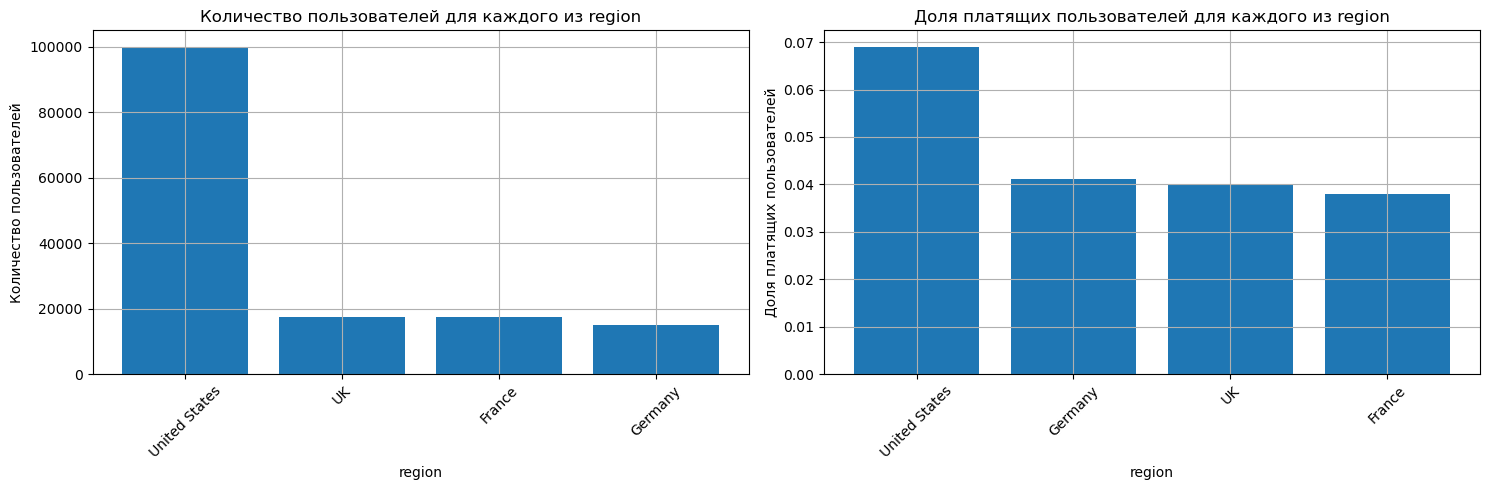

In [44]:
plot_df(df_region, factor)

#### Вывод
С отрывом по количеству привлеченных пользователей ушла США с отметкой в 100002 пользователей, далее с небольшой разницей идут такие страны, как: Великобритания(17575), Франция(17450), Германия(14981).
Лидер по доле платящих пользователей все тот же, но отрыв уже не так велик: США(0.07), Германия(0.041), Великобритания(0.04), Франция(0.038).

---

### Сравнение устройств по количеству привлеченных пользователей и по доле покупалетей.

In [48]:
factor = 'device'
df_device = get_df(profiles, factor)
df_device

count  count_payers
device                      
Android  35032      0.058518
Mac      30042      0.063644
PC       30455      0.050468
iPhone   54479      0.062079

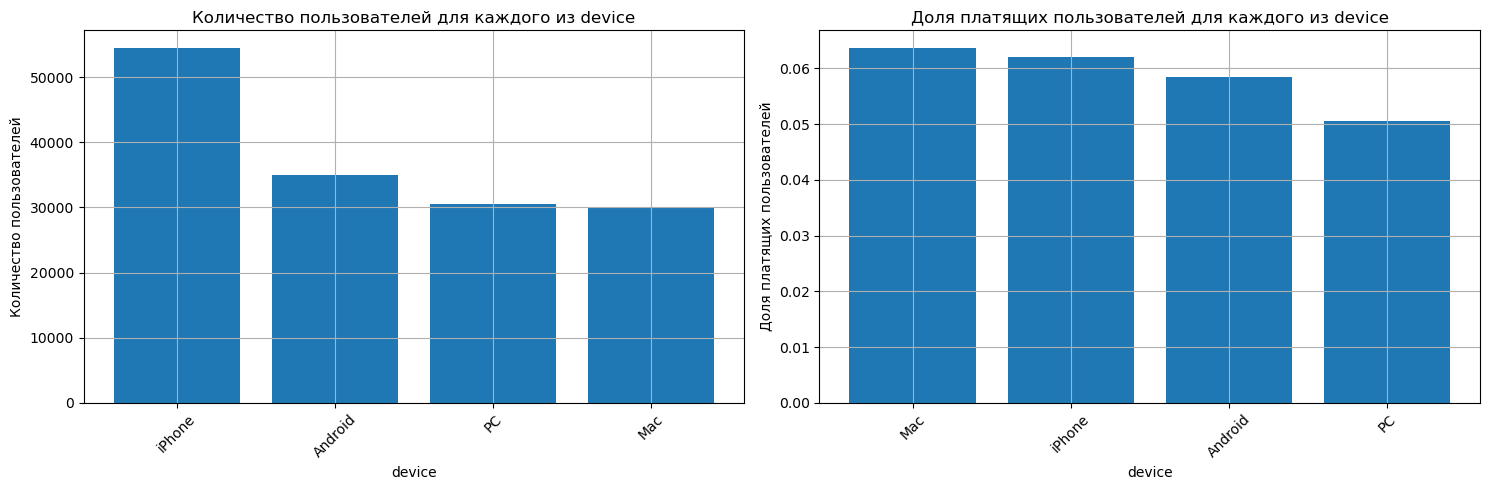

In [49]:
plot_df(df_device, factor)

По количеству пользователей лидирует iPhone с большим отрывом(54479). Далее идут такие устройства, как Android(35032), PC(30455), Mac(30042). А в долях покупателей прошлый лидер уже скатился до второго места с небольшой разницей: Mac(0.063), iPhone(0.062), Android(0.059), PC(0.05).

---

### Сравнение рекламных источников привлечения по количеству привлеченных пользователей и по доле покупалетей.

In [53]:
factor = 'channel'
df_channel = get_df(profiles, factor)
df_channel

count  count_payers
channel                                
AdNonSense           3880      0.113402
FaceBoom            29144      0.122049
LeapBob              8553      0.030633
MediaTornado         4364      0.035747
OppleCreativeMedia   8605      0.027077
RocketSuperAds       4448      0.079137
TipTop              19561      0.096007
WahooNetBanner       8553      0.052964
YRabbit              4312      0.038265
lambdaMediaAds       2149      0.104700
organic             56439      0.020553

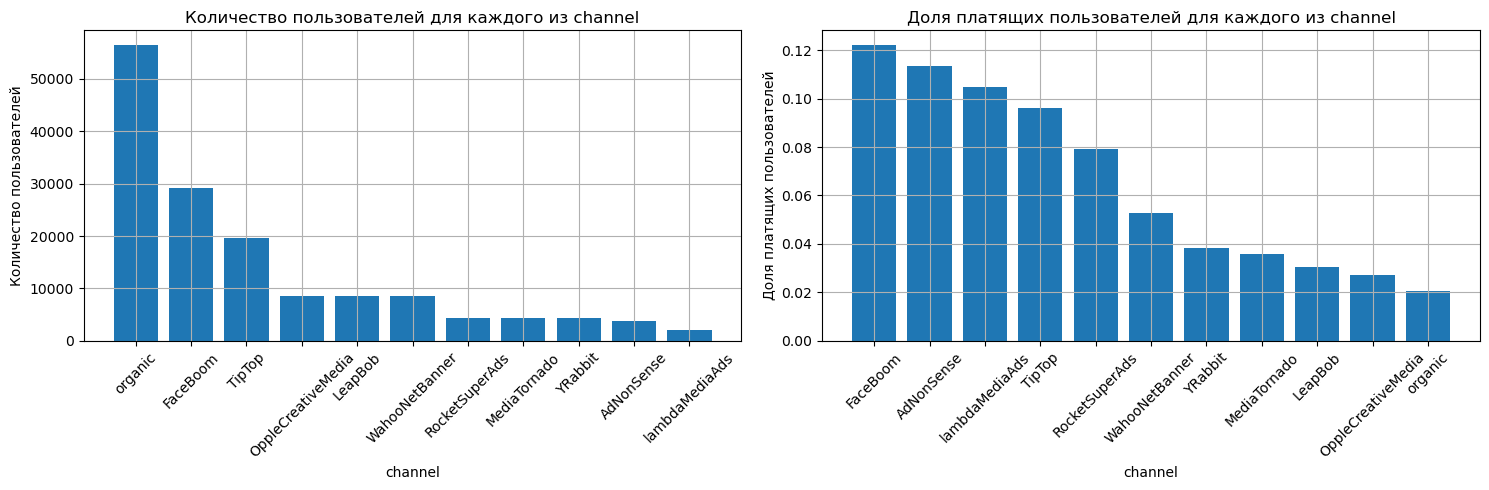

In [54]:
plot_df(df_channel, factor)

В количестве привлеченных пользователей лидирует organic, видимо рекламы не такие уж и мощные. Зато в доле платящих нет лидера с отрывом, на первых местах: FaceBoom, AdNonSense, lambdaMediaAds, TipTop, RocketSuperAds. А organic находится на последнем месте.

---

## Маркетинг

---

### Общая сумма расходов на маркетинг

In [61]:
display(costs['costs'].sum())

105497.30000000002

Общая сумма составила 105497.3

---

### Стоимость каждого источника

---



channel
AdNonSense             3911.25
FaceBoom              32445.60
LeapBob                1797.60
MediaTornado            954.48
OppleCreativeMedia     2151.25
RocketSuperAds         1833.00
TipTop                54751.30
WahooNetBanner         5151.00
YRabbit                 944.22
lambdaMediaAds         1557.60
Name: costs, dtype: float64

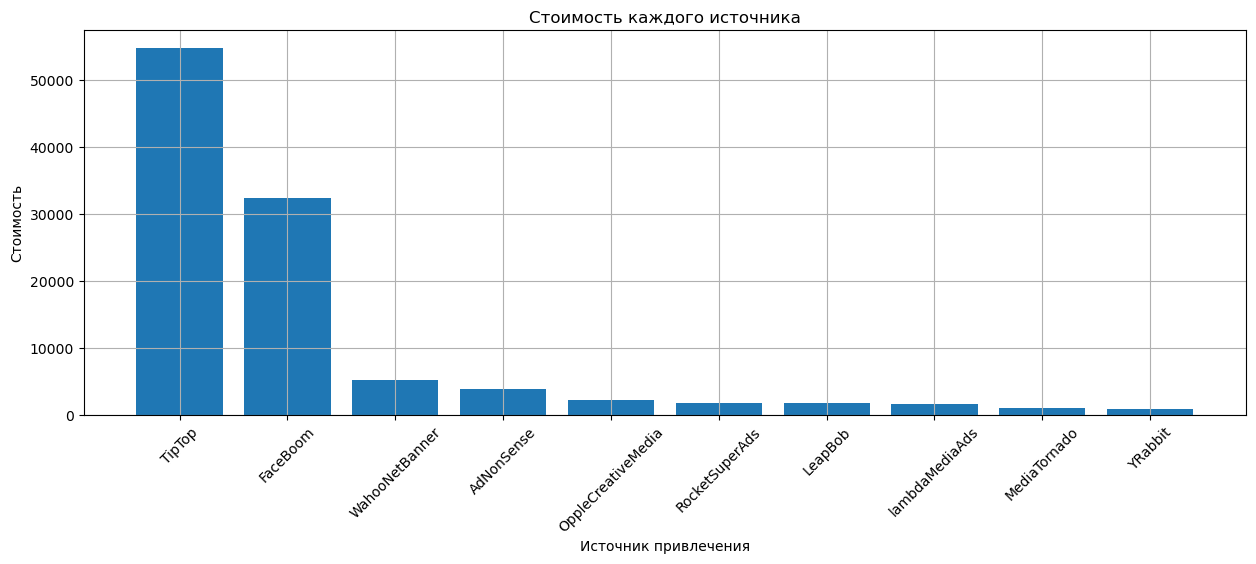

In [65]:
channel_money = costs.groupby('channel')['costs'].sum()
display(channel_money)

channel_money = channel_money.sort_values(ascending = False)
plt.figure(figsize = (15, 5))
plt.bar(channel_money.index, channel_money)
plt.title('Стоимость каждого источника')
plt.xlabel('Источник привлечения')
plt.ylabel('Стоимость')
plt.xticks(rotation = 45)
plt.grid(True)
plt.show()

Самым дорогим источником с отрывом оказался TipTop, он стоит больше половины всего бюджета(54751 из 105497), далее идет FaceBoom. На последних местах источники, между которыми небольшая разница: lambdaMediaAds, MediaTornado, YRabbit.

---

### Динамика изменения расходов по неделям и месяцам на источники

In [69]:
profiles.head()

user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769

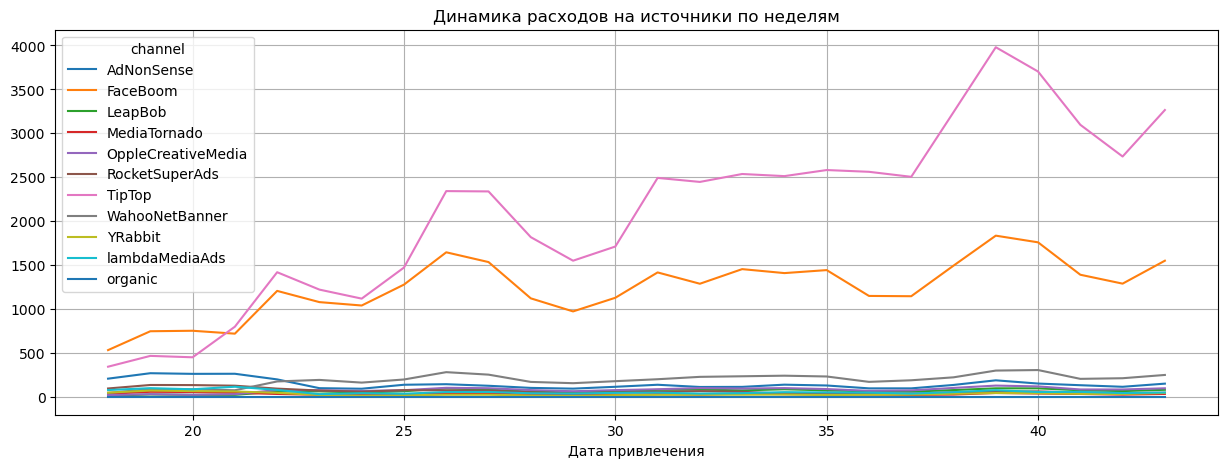

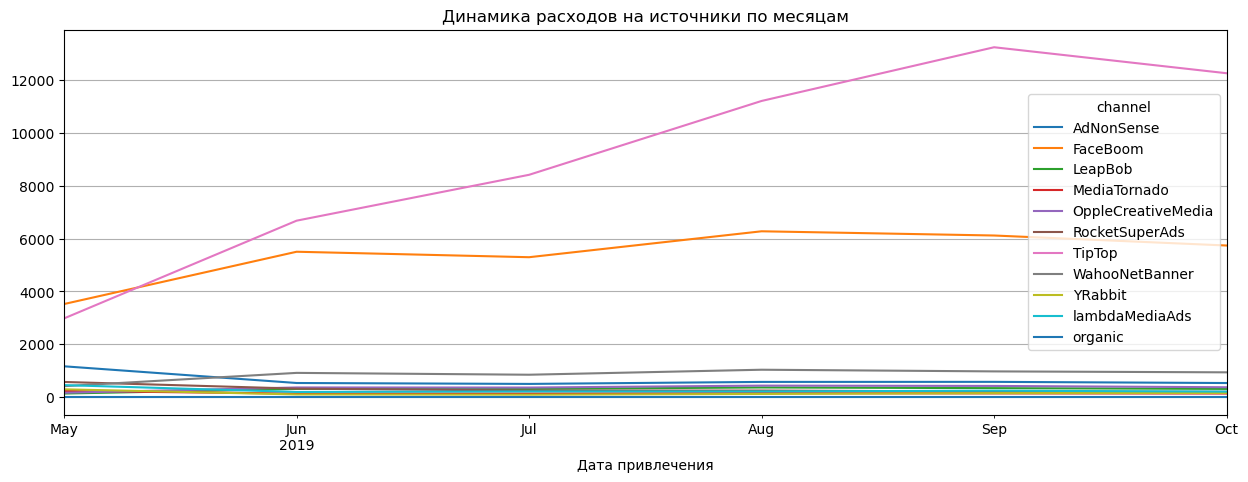

In [70]:
profiles['dt_week'] = profiles['first_ts'].dt.isocalendar().week

filtered_data = profiles.pivot_table(index = 'dt_week', columns = 'channel', values = 'acquisition_cost', aggfunc = 'sum')
filtered_data.plot(grid = True, figsize = (15, 5))
plt.xlabel('Дата привлечения')
plt.title('Динамика расходов на источники по неделям')

filtered_data = profiles.pivot_table(index = 'month', columns = 'channel', values = 'acquisition_cost', aggfunc = 'sum')
filtered_data.plot(grid = True, figsize = (15, 5))
plt.xlabel('Дата привлечения')
plt.title('Динамика расходов на источники по месяцам')

plt.show()

Источники TipTop и FaceBoom что по неделям, что по месяцам все растут, при этом лидирует TipTop, после 30 недели в два раза и более. Остальные источники не меняются, имеют стабильную стоимость за одного клиента. Осталось понять, какие трафики все-таки оказались выгоднее.

---

### Стоимость одного привлеченного пользователя для всех источников

In [75]:
profiles.head()

user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  dt_week  
0  2019-05-07 2019-05-01   True          1.088172       19  
1  2019-07-09 2019-07-01  False          1.107237       28  
2  2019-10-01 2019-10-01  False          0.000000       40  
3  2019-08-22 2019-08-01  False          0.988235       34  
4  2019-10-02 2019-10-01  False          0.230769       40

costs  quantity       cac
channel                                         
TipTop              54751.30     19561  2.799003
FaceBoom            32445.60     29144  1.113286
AdNonSense           3911.25      3880  1.008054
lambdaMediaAds       1557.60      2149  0.724802
WahooNetBanner       5151.00      8553  0.602245
RocketSuperAds       1833.00      4448  0.412095
OppleCreativeMedia   2151.25      8605  0.250000
YRabbit               944.22      4312  0.218975
MediaTornado          954.48      4364  0.218717
LeapBob              1797.60      8553  0.210172
organic                 0.00     56439  0.000000

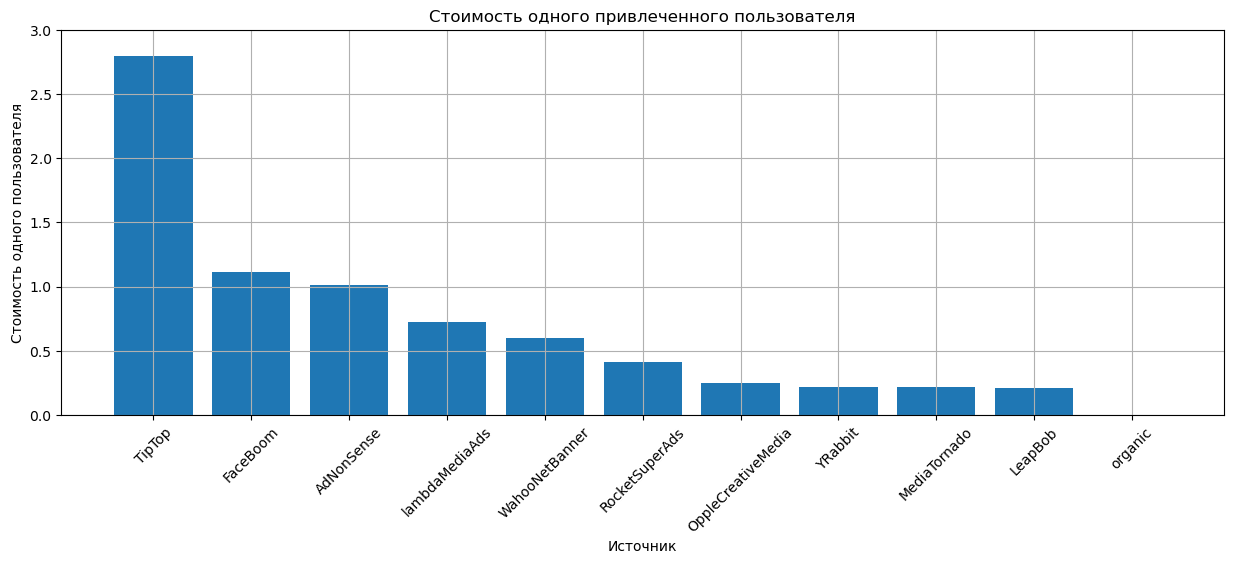

In [76]:
cac_df = profiles.groupby('channel').agg({'acquisition_cost': 'sum', 'user_id': 'nunique'}).rename(columns = {'acquisition_cost': 'costs', 'user_id': 'quantity'})
cac_df['cac'] = cac_df['costs'] / cac_df['quantity']
cac_df = cac_df.sort_values(by = 'cac', ascending = False)
display(cac_df)

plt.figure(figsize = (15, 5))
plt.bar(cac_df.index, cac_df['cac'])
plt.title('Стоимость одного привлеченного пользователя')
plt.xlabel('Источник')
plt.ylabel('Стоимость одного пользователя')
plt.grid(True)
plt.xticks(rotation = 45)
plt.ylim(0, 3)
plt.show()

Как выяснилось средние траты на Tiptop превысили остальные компании в 2.5 раза и более. Как и ожидалось, "органические" пользователи были для компании бесплатными. Можно заметить, хоть и FaceBoom не самый дорогой источник, зато привел пользователей больше всех, так еще и с отрывом.

---

## Оценка окупаемости рекламы

---

Исключим пользователей, пришедших естественным путем. Ведь они не входят в расходы компании.

In [83]:
profiles = profiles.query('acquisition_cost != 0')
profiles.head()

user_id            first_ts     channel   device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom      Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom   iPhone  United States   
3  22593348 2019-08-22 21:35:48  AdNonSense       PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit   iPhone  United States   
7  46006712 2019-06-30 03:46:29  AdNonSense  Android         France   

           dt      month  payer  acquisition_cost  dt_week  
0  2019-05-07 2019-05-01   True          1.088172       19  
1  2019-07-09 2019-07-01  False          1.107237       28  
3  2019-08-22 2019-08-01  False          0.988235       34  
4  2019-10-02 2019-10-01  False          0.230769       40  
7  2019-06-30 2019-06-01   True          1.008000       26

### Окупаемость рекламы. LTV, ROI. Графики динамики LTV, ROI, COC.

In [85]:
observation_date = datetime(2019, 11, 1).date()
horizon = 14

Поскольку за окном 1 ноября 2019 года, значит это и будет моментом анализа. А так как окупаемость не позднее чем через 2 недели, горизонтом анализа будет 14.

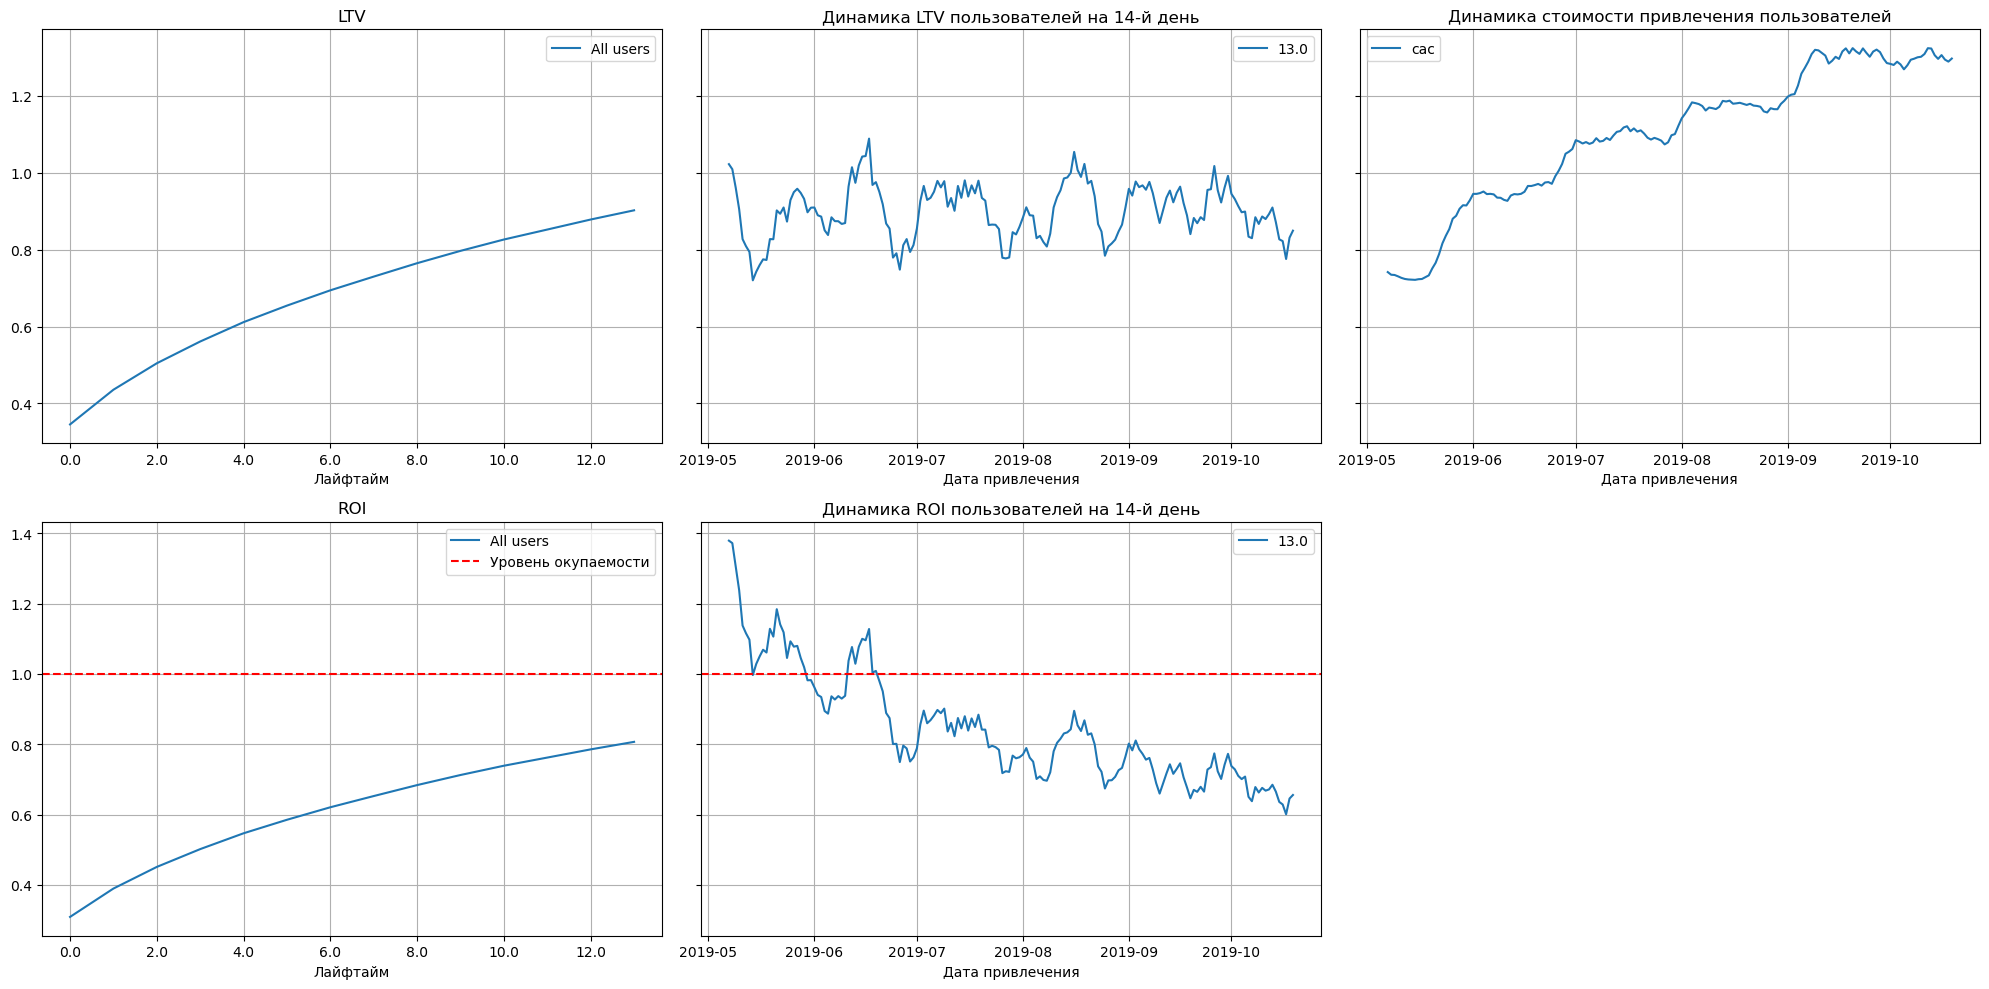

In [92]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles, orders, observation_date, horizon)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon)

Можно сразу понять:
* LTV не понижается, следовательно данные отобраны правильно.
* LTV стабилен.
* CAC резко поднимается(как раз в тот месяц, когда увеличилась цена за одного пользователя на таких источниках, как TipTop и FaceBoom).
* По графику ROI видно, что прибыль компании через 2 недели доходит только до 80% от расходов на рекламу. Компания теряет деньги.
* По динамике ROI видно, что прибыль проседает как раз в июне, тогда же и происходит аномальый рост CAC.

Пока что можно предположить, что убытки происходят из-за резкого роста цены привлечения одного клиента.

---

### Конверсия, удержание пользователей и динамика их изменений

---

#### Конверсия и удержания с разбивкой по устройствам

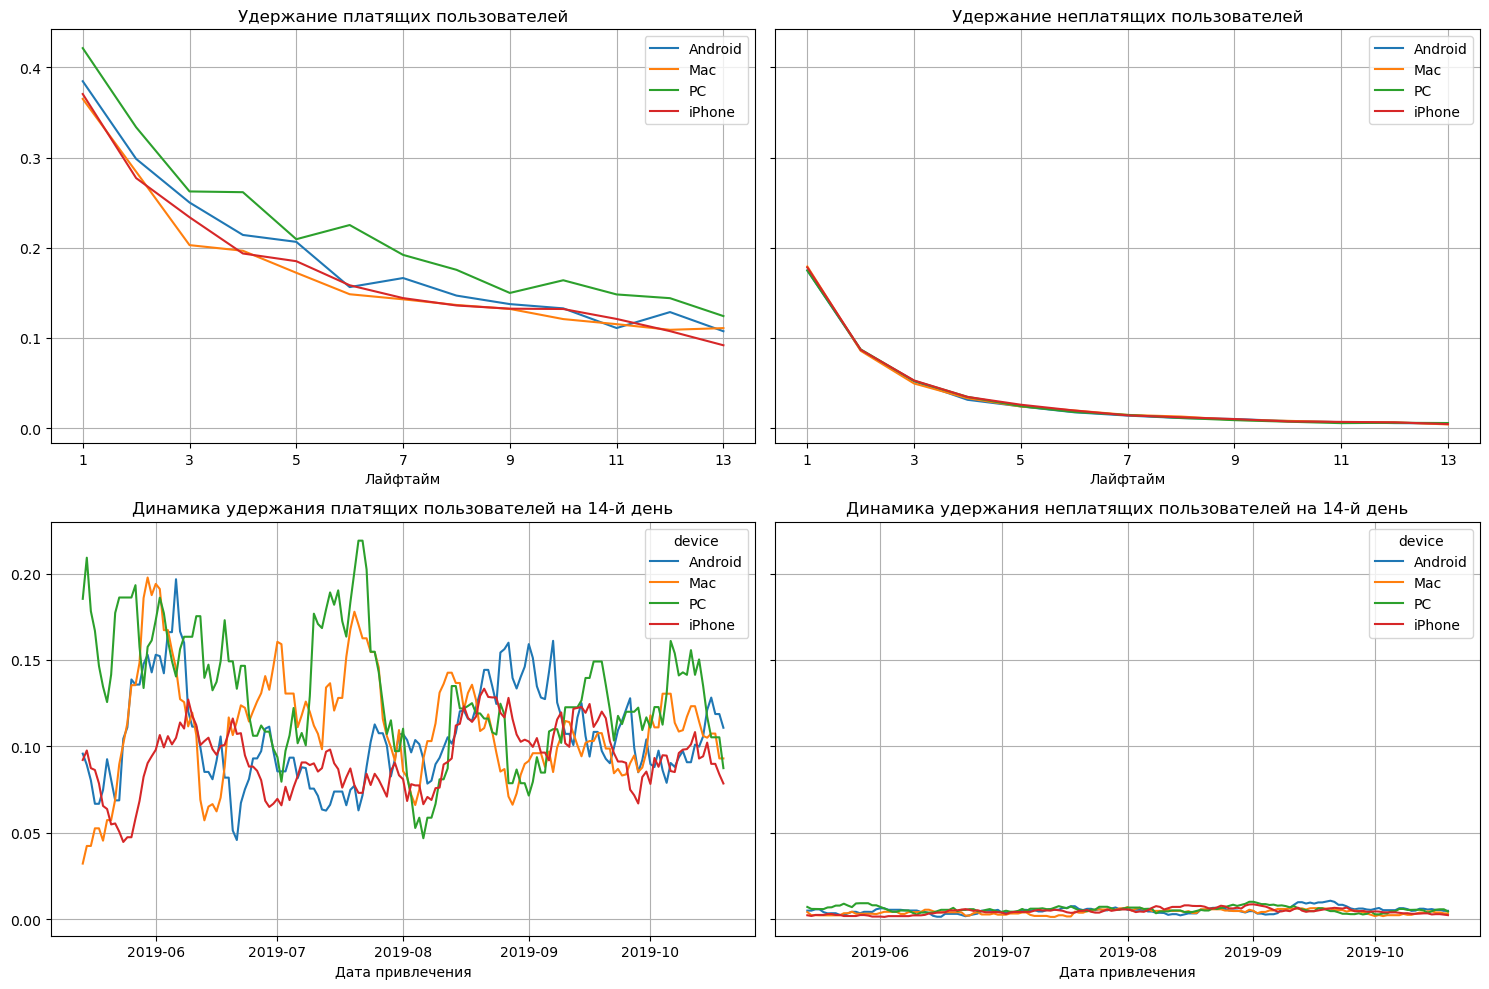

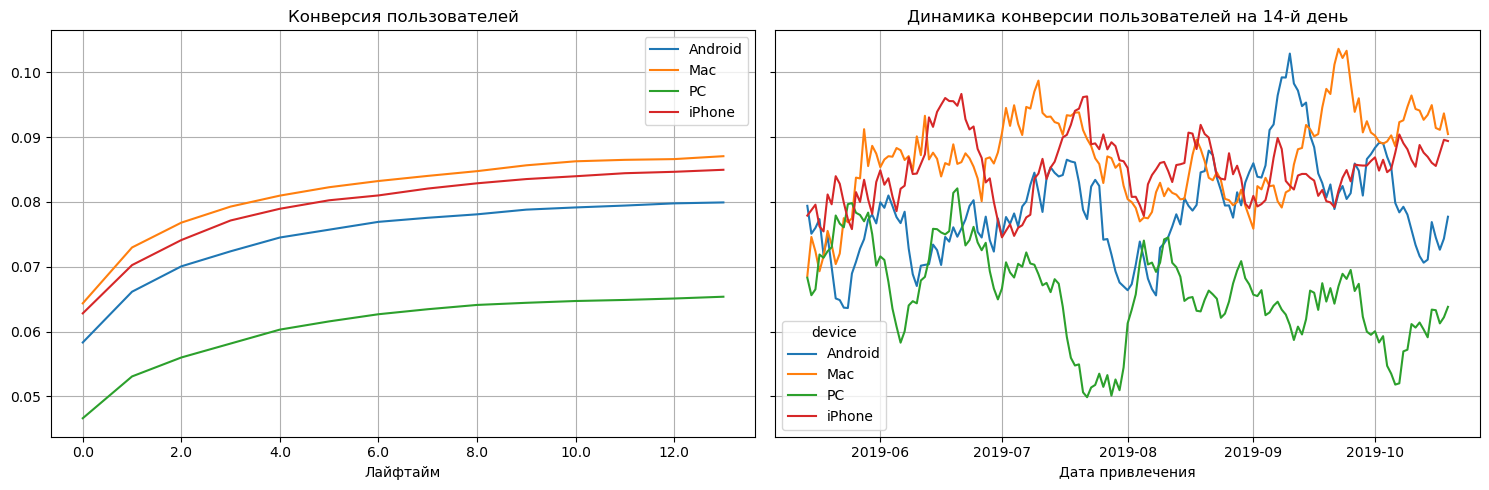

In [99]:
dimensions = ['device']
window = 14
retention_raw, retention_grouped, retention_history = get_retention(profiles, visits, observation_date, horizon, dimensions)
conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles, orders, observation_date, horizon, dimensions)

plot_retention(retention_grouped, retention_history, horizon, window)
plot_conversion(conversion_grouped, conversion_history, horizon, window)

Удержание примерно у всех устройств одинаковая, пользователи PC удерживаются лучше остальных. На 14 день динамика удержания так же у всех похожая, но видны частые точки роста у PC. Удержания неплатящих пользователей и ее динамика у всех идентичная. Что же касается конвертации, то у Mac, iPhone и Android она не сильно различается, хоть и виден лидер - Mac. А вот конверсия пользователей с устройством PC с отрывом ниже всех. Возможно, есть проблемы с оплатой у пользователей с этим устройством. Стоит обратить внимание на их окупаемость.

#### Конверсия и удержания с разбивкой по странам

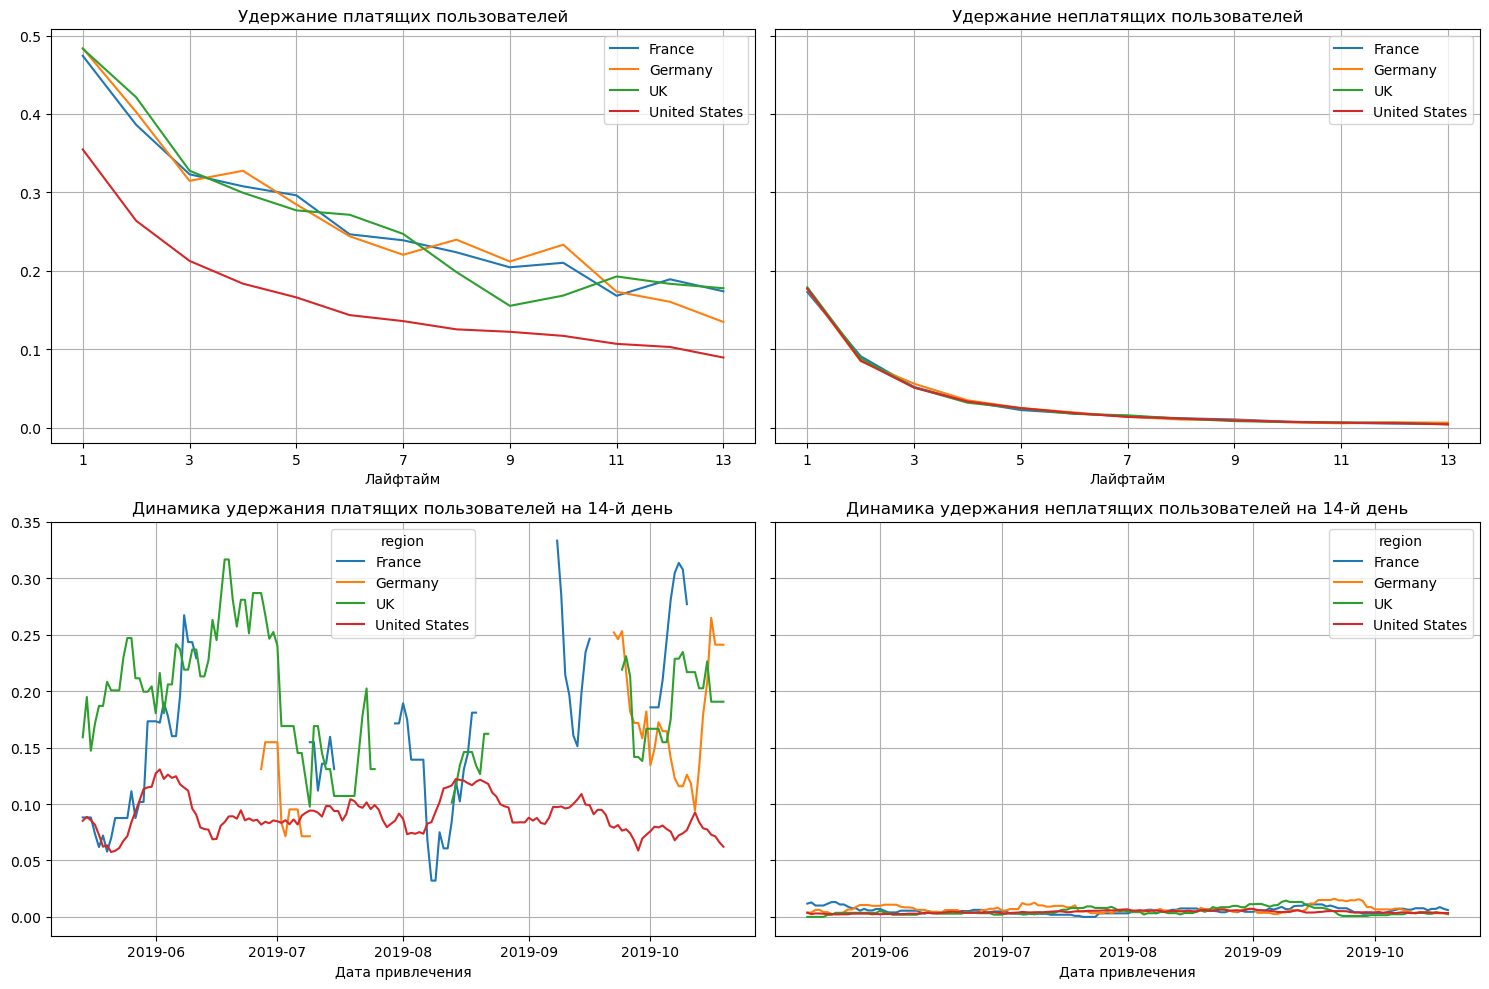

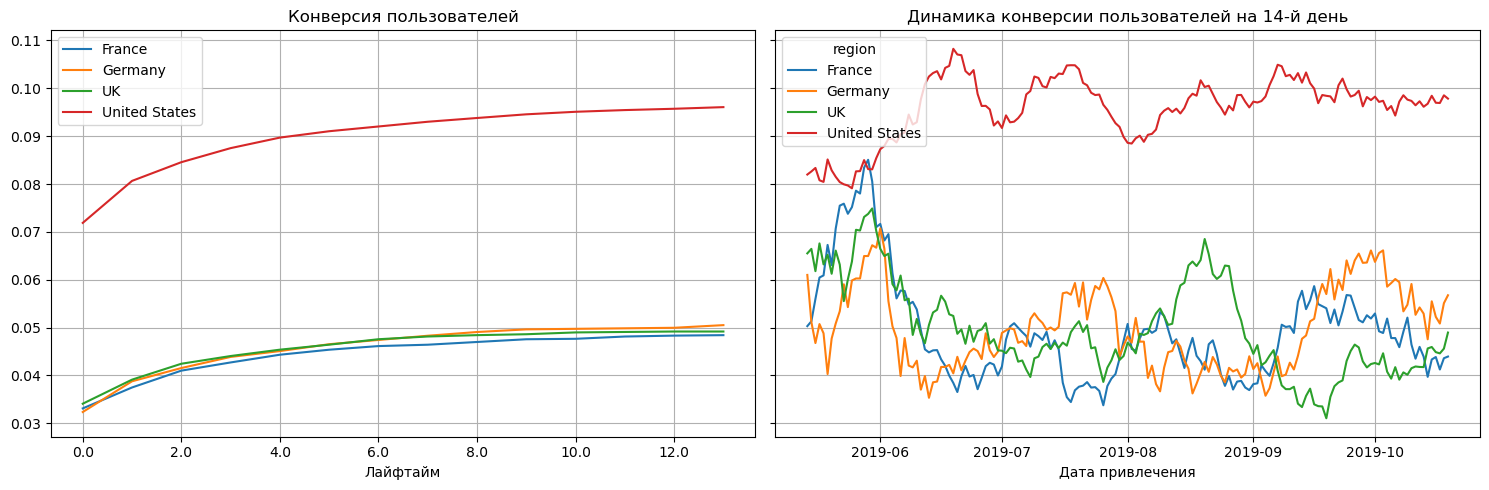

In [102]:
dimensions = ['region']
window = 14
retention_raw, retention_grouped, retention_history = get_retention(profiles, visits, observation_date, horizon, dimensions)
conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles, orders, observation_date, horizon, dimensions)

plot_retention(retention_grouped, retention_history, horizon, window)
plot_conversion(conversion_grouped, conversion_history, horizon, window)

Удержание неплатящих пользователей и ее динамика у всех стабильно равна. А удержание платящих так же равна у всех стран за исключением United States, что и в динамике оно стабильно низкое. Что же касается конверсии, то тут все наоборот: у всех стран она похожа(3-4%), а у United States она выше всех почти в два раза(6-7%). Такая же ситуация и на графике динамики 14 дня. Получается, американские пользователи приносят больше всех денег, но при этом раньше всех уходят.

#### Конверсия и удержания с разбивкой по рекламным каналам

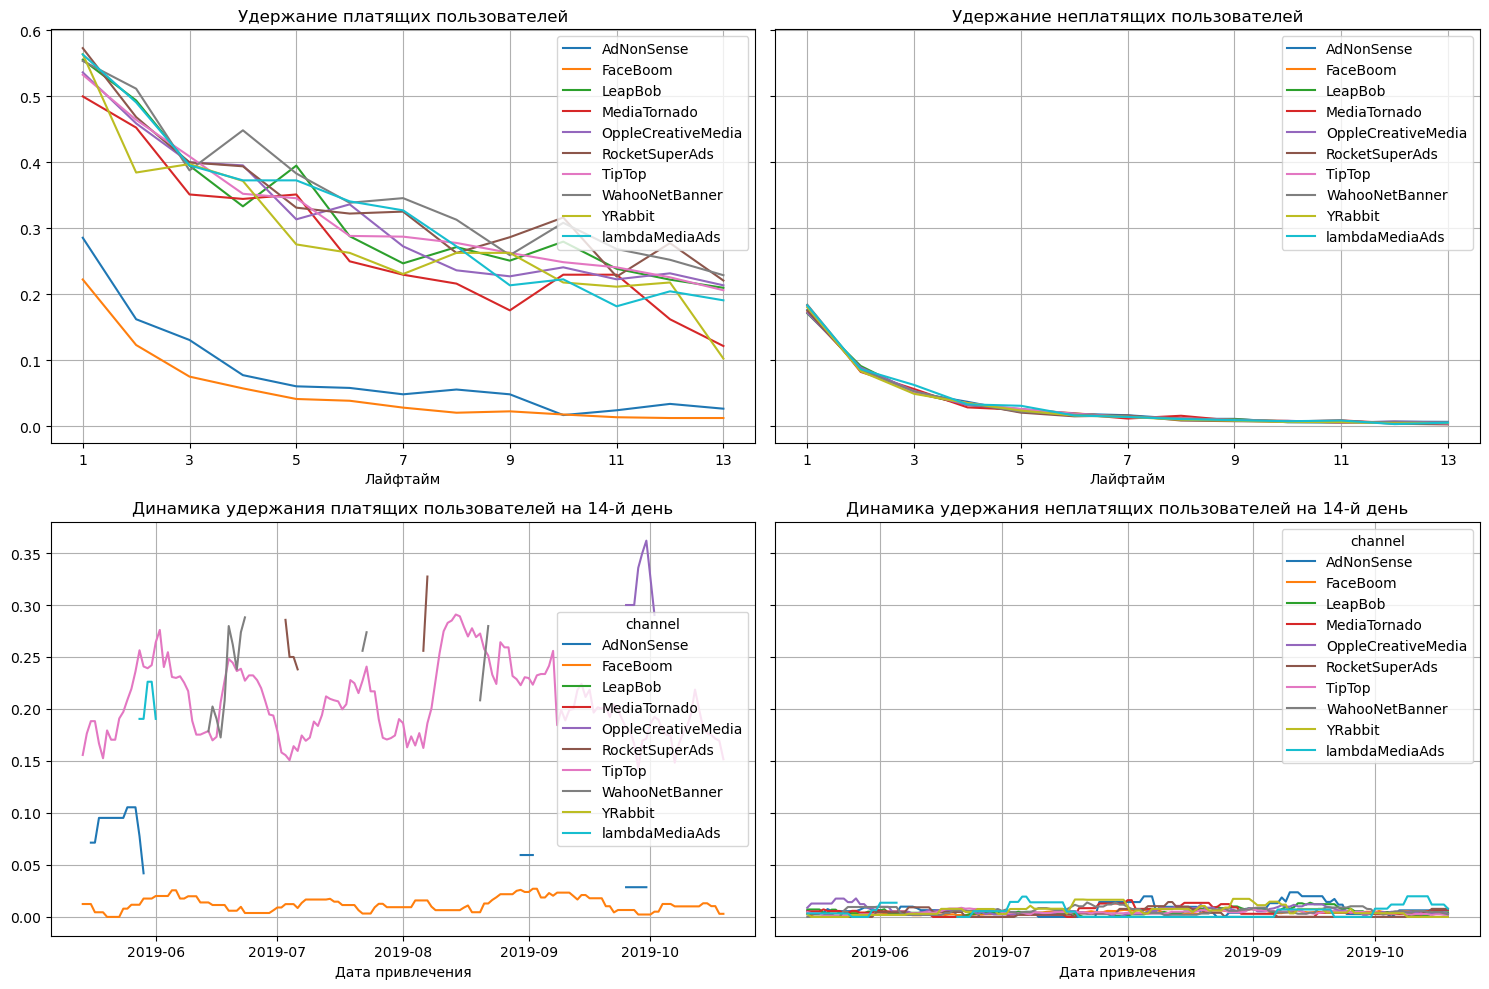

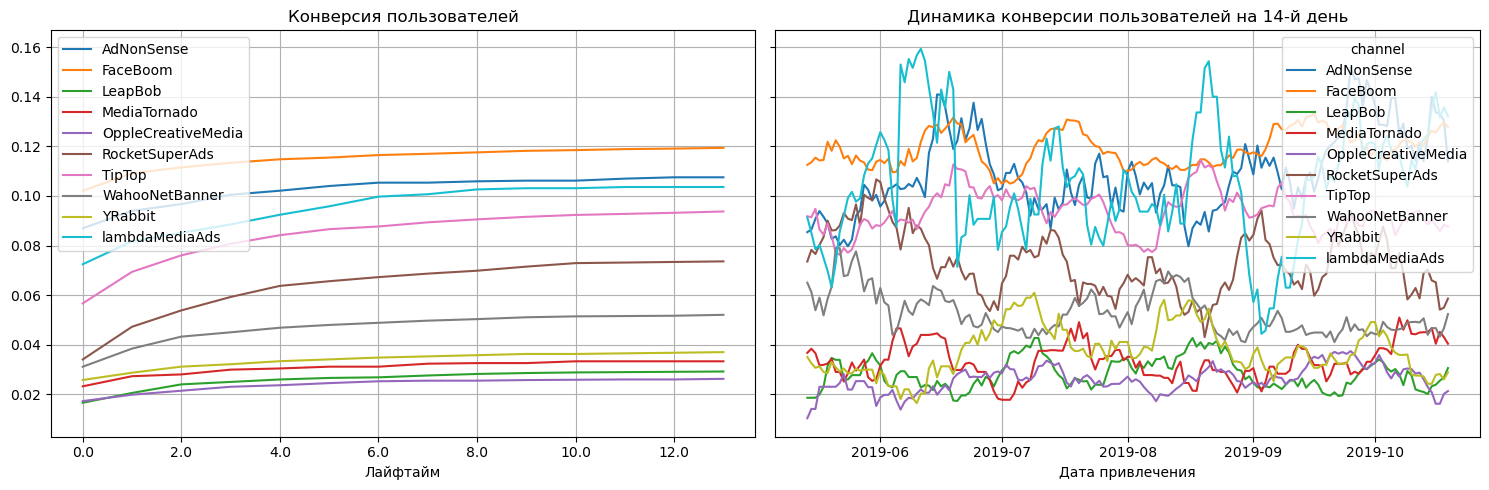

In [105]:
dimensions = ['channel']
window = 14
retention_raw, retention_grouped, retention_history = get_retention(profiles, visits, observation_date, horizon, dimensions)
conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles, orders, observation_date, horizon, dimensions)

plot_retention(retention_grouped, retention_history, horizon, window)
plot_conversion(conversion_grouped, conversion_history, horizon, window)

Удержание неплатящих пользователей от всех трафиков одинаково низкая. Удержание платящих совпадает у трафиков, кроме FaceBoom и AdNonSense, у них стабильно на 30% пользователей меньше удерживаются, чем у остальных. А по динамике удержания можно заметить, что на 14 день каждого месяца только FaceBoom близится к нулю в течение всего периода. При этом конверсия у последнего лучше всех, лидирует, опережая стабильно на 1% следующего по доле трафика. На 14 день динамика у FaceBoom стабильно высока, но lambdaMediaAds в июне и с августа по ноябрь иногда все-таки становится выше. AdNonSense же только в июне, конце сентября и начале октября выше.

---

### Окупаемость рекламы с разбивкой по устройствам

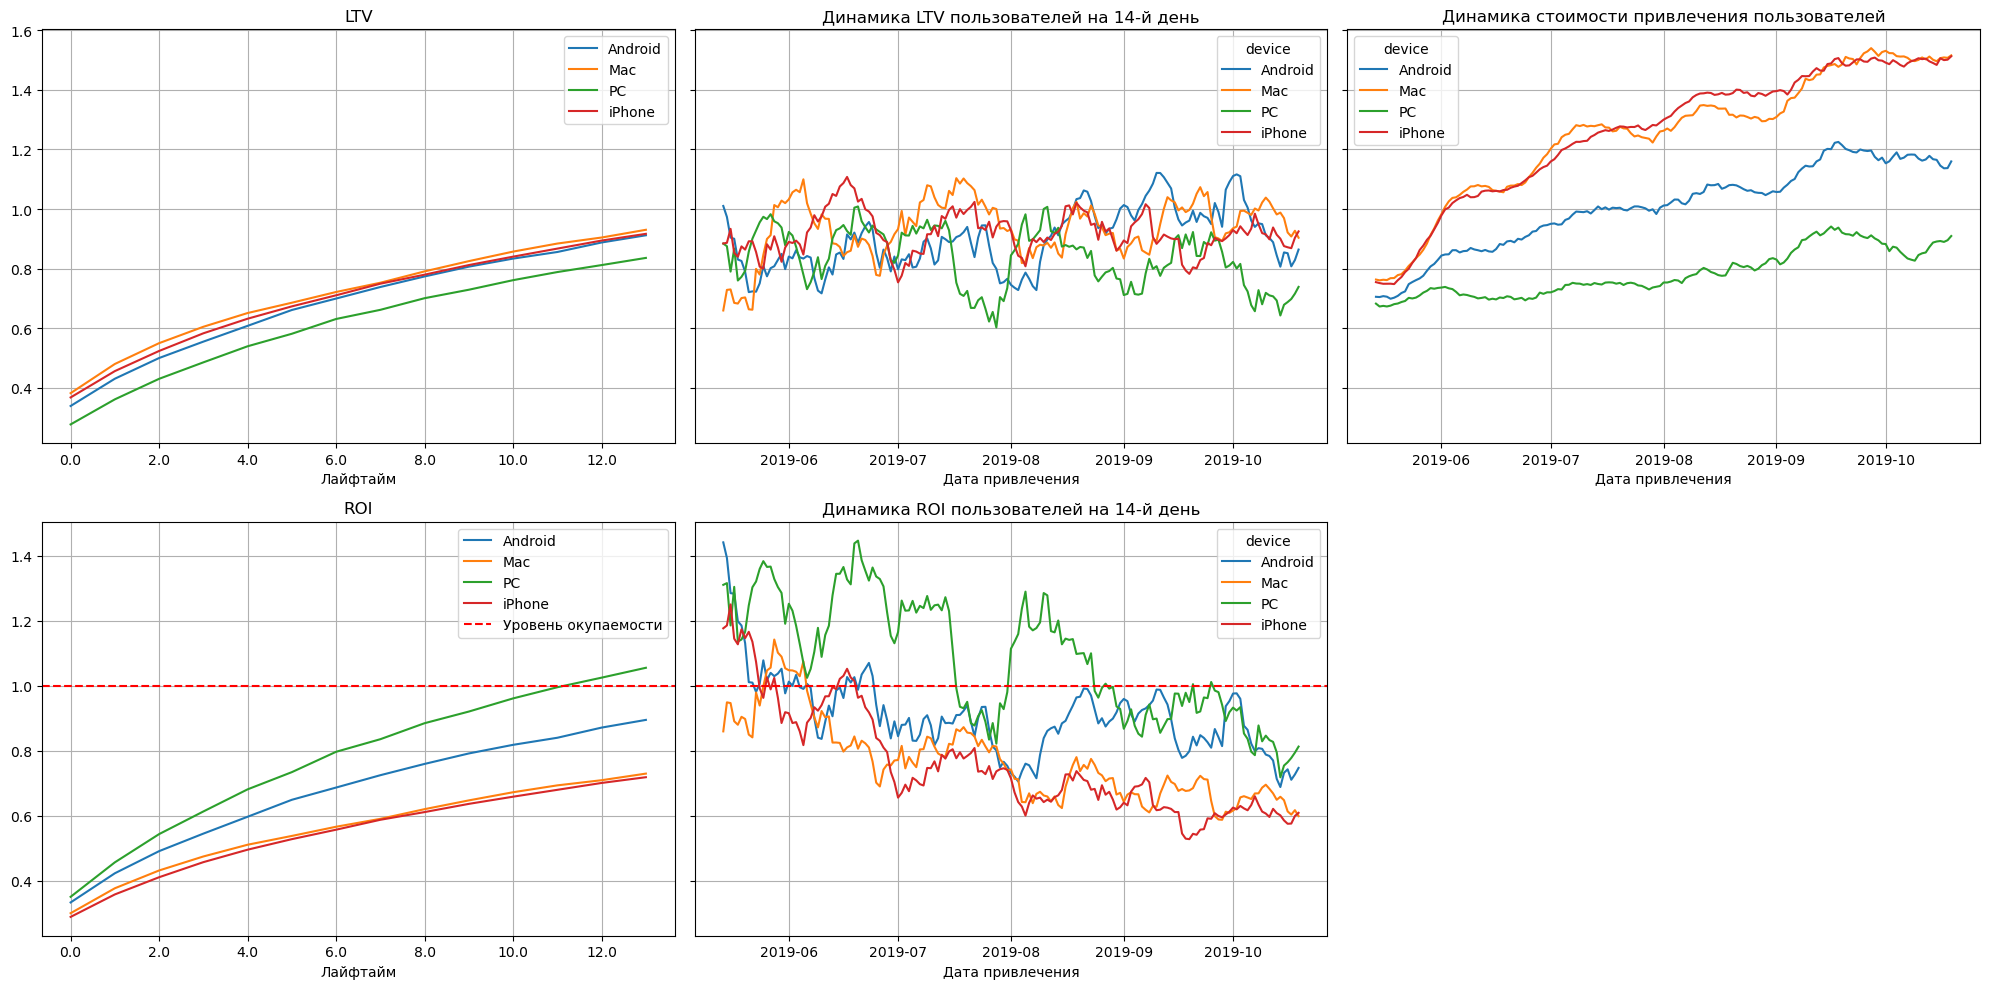

In [110]:
dimensions = ['device']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles, orders, observation_date, horizon, dimensions)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon, window)

По данным графикам становится ясно, что:
* LTV у всех приблизительно одинаковый, выделяется только PC. А это значит, что пользователи с устройством PC тратят на приложение меньше денег, чем остальные.
* Динамика стоимости привлечения клиентов(САС) у всех возрастает в июне, когда подоражали трафики TipTop и FaceBoom. Но самыми "дешевыми" пользователи оказываются те, у кого PC. Дальше идут с устройством Android, а остальные примерно одинаково дорогие.
* ROI перескакивает за единицу только у пользователей PC через 11 дней после прихода в приложение. Пользователи с устройством Android приносят дохода лишь 90% от расходов, а с устройствами Mac, iPhone окупают лишь 70% рахсходов на рекламу.
* Динамика ROI показывает, что окупаемость пользователей начинает падать в июне. И к концу всего рассматриваемого периода пользователи со всех устройств перестают окупаться.

Рекомендую маркетологам обратить внимание, что самыми выгодными являются пользователи с утройством PC. Ведь они стоят дешевле остальных, при этом принося больше всех прибыли. Также обратить внимание на то, откуда привлекаются пользователи с устройствами iPhone и Mac, они приносят денег больше, чем пользователи с PC, но стоят куда дороже.

---

### Окупаемость рекламы с разбивкой по странам


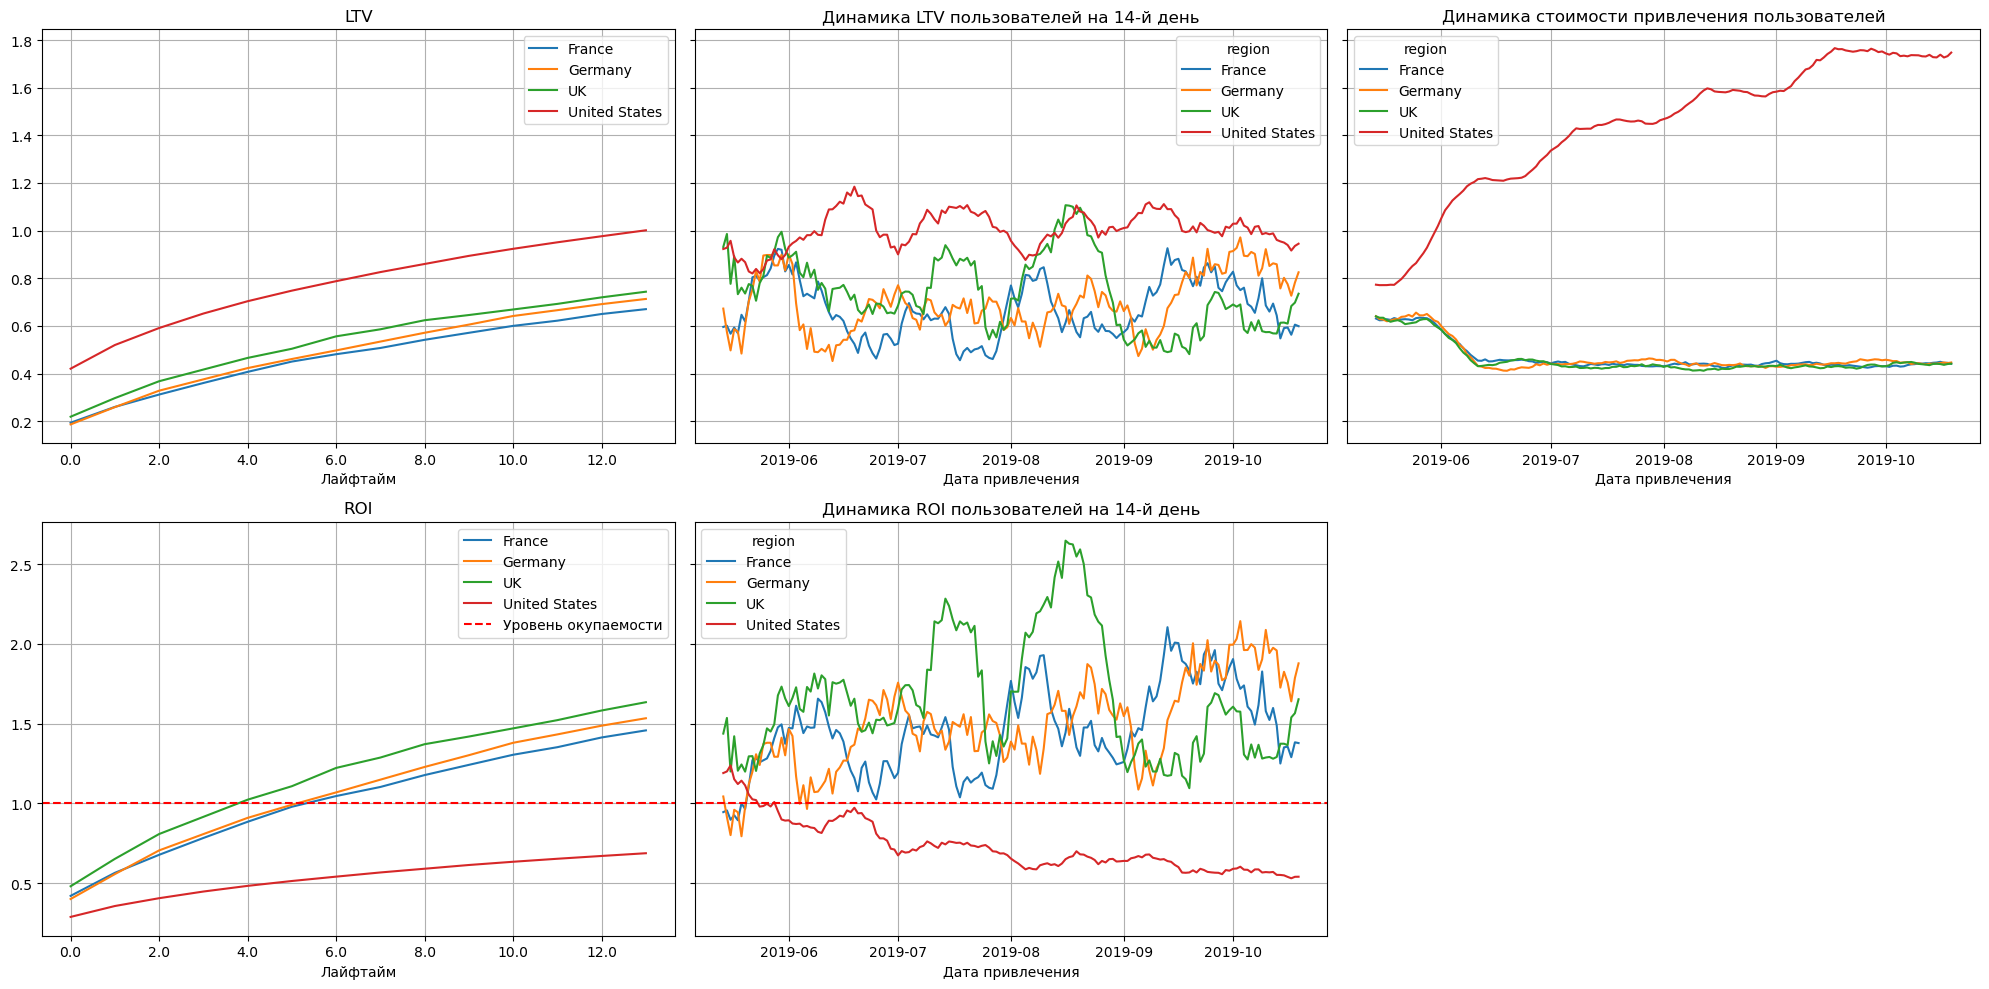

In [116]:
dimensions = ['region']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles, orders, observation_date, horizon, dimensions)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon, window)

Теперь все стало понятно. Скорее всего, резкое подорожание рекламы было только для территории United States, поскольку в остальных странах нет такого скачка в цене за одного пользователя в июне. Также на динамике ROI в 14 день видно, что только United States перестали окупаться начиная с июня. Либо же только в этой стране приходят из таких источников, как TipTop и FaceBoom, что маловероятно. Несмотря даже на то, что пользователи из United States тратят денег больше всех, это не помогает компании окупать их привлечение. А пользователи со всех других стран приносят прибыль уже через 2 дня после прихода на приложение.

Рекламному отделу рекомендую пересмотреть трафики, с которых приходят жители United States. Возможно найдутся другие более дешевые источники, с которых так же сможет приходить данная группа.

---

### Стоимость рекламы с разбивкой по рекламным каналам

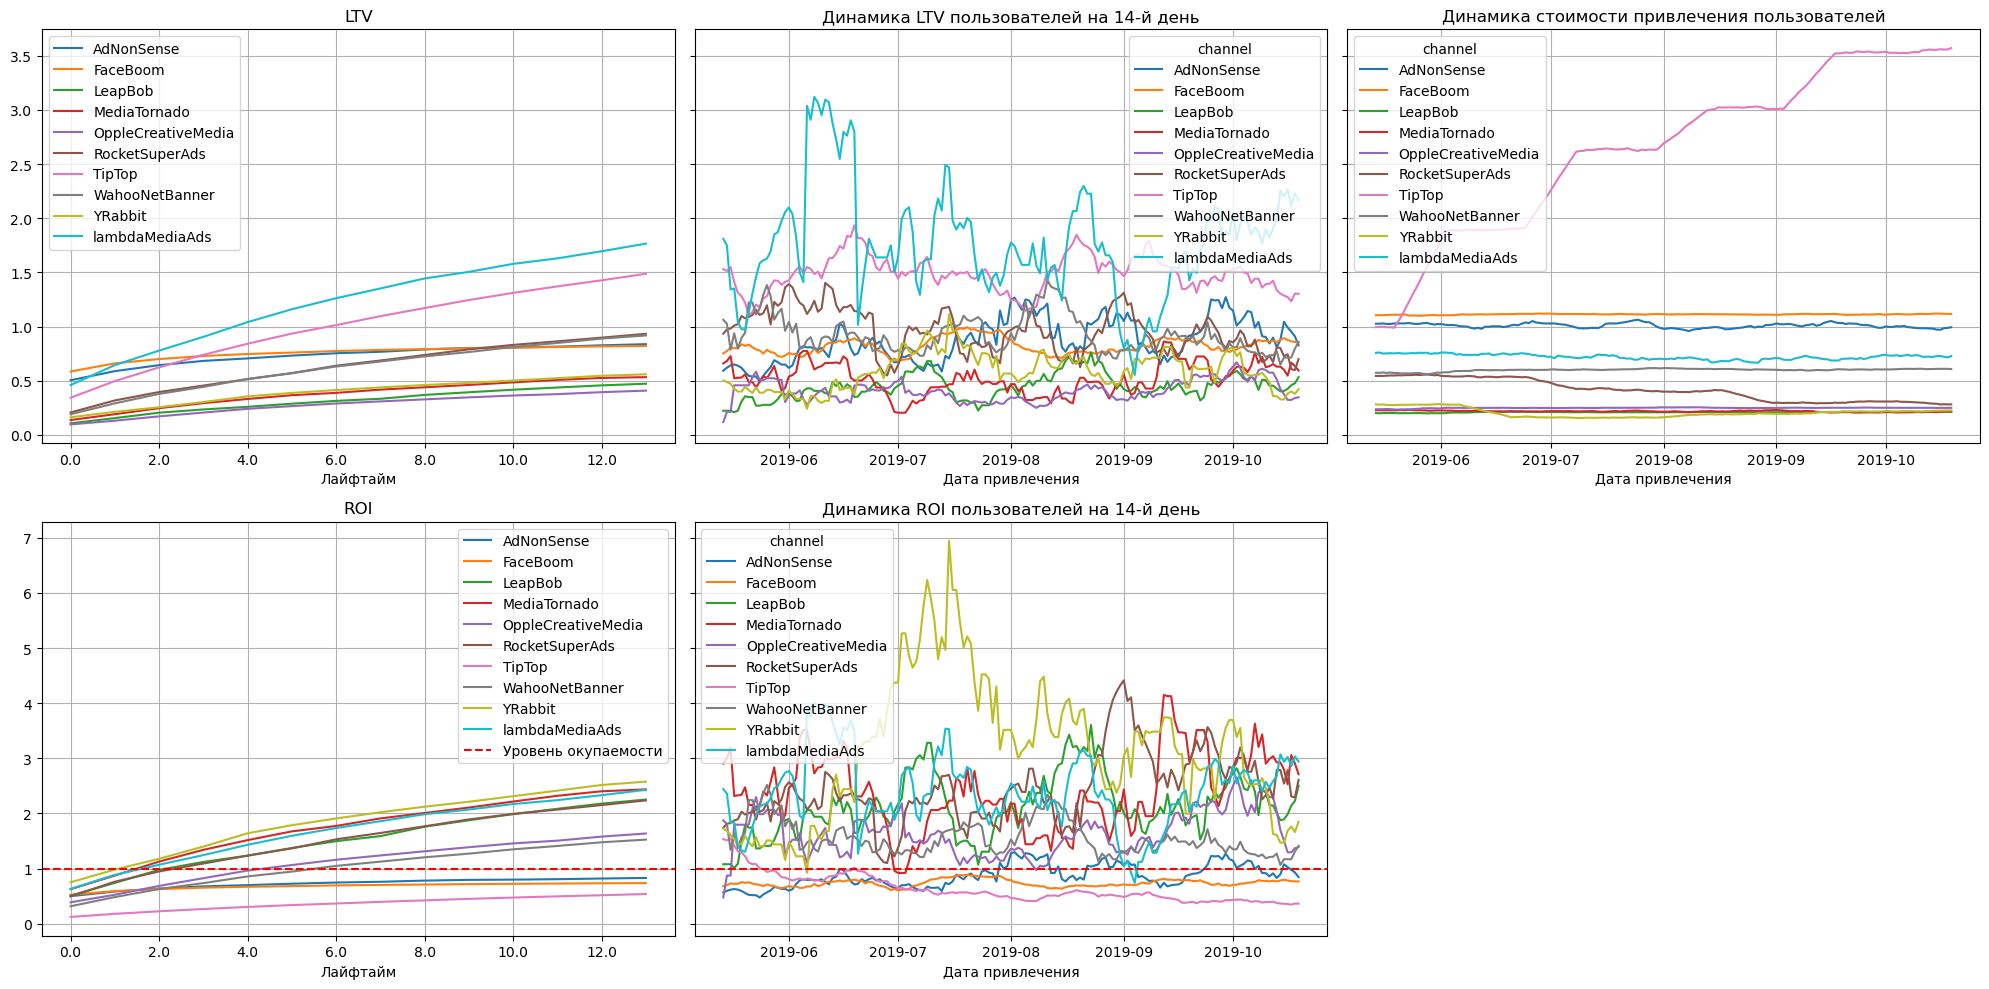

In [122]:
dimensions = ['channel']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles, orders, observation_date, horizon, dimensions)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon, window)

Посмотрим подробнее источники, которые не окупаются

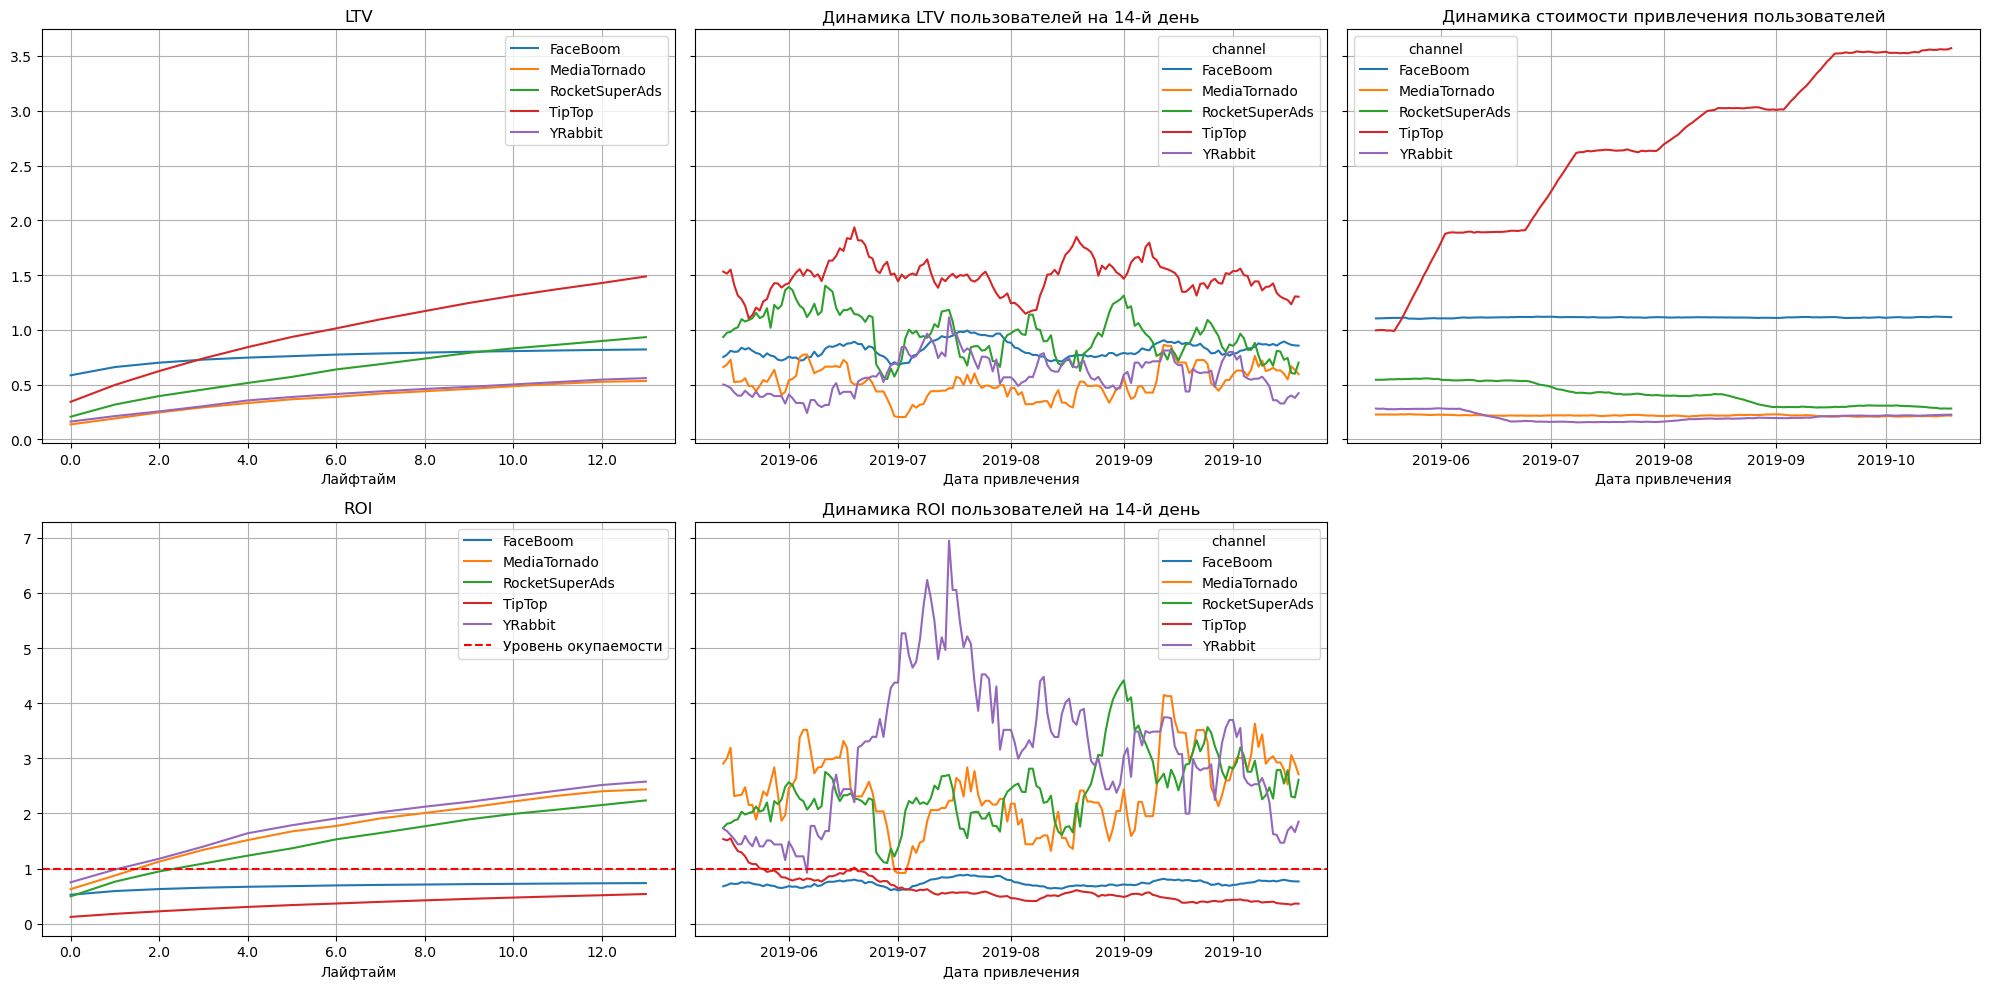

In [124]:
profiles_faceboom = profiles.query('region == "United States"')
dimensions = ['channel']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles_faceboom, orders, observation_date, horizon, dimensions)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon, window)

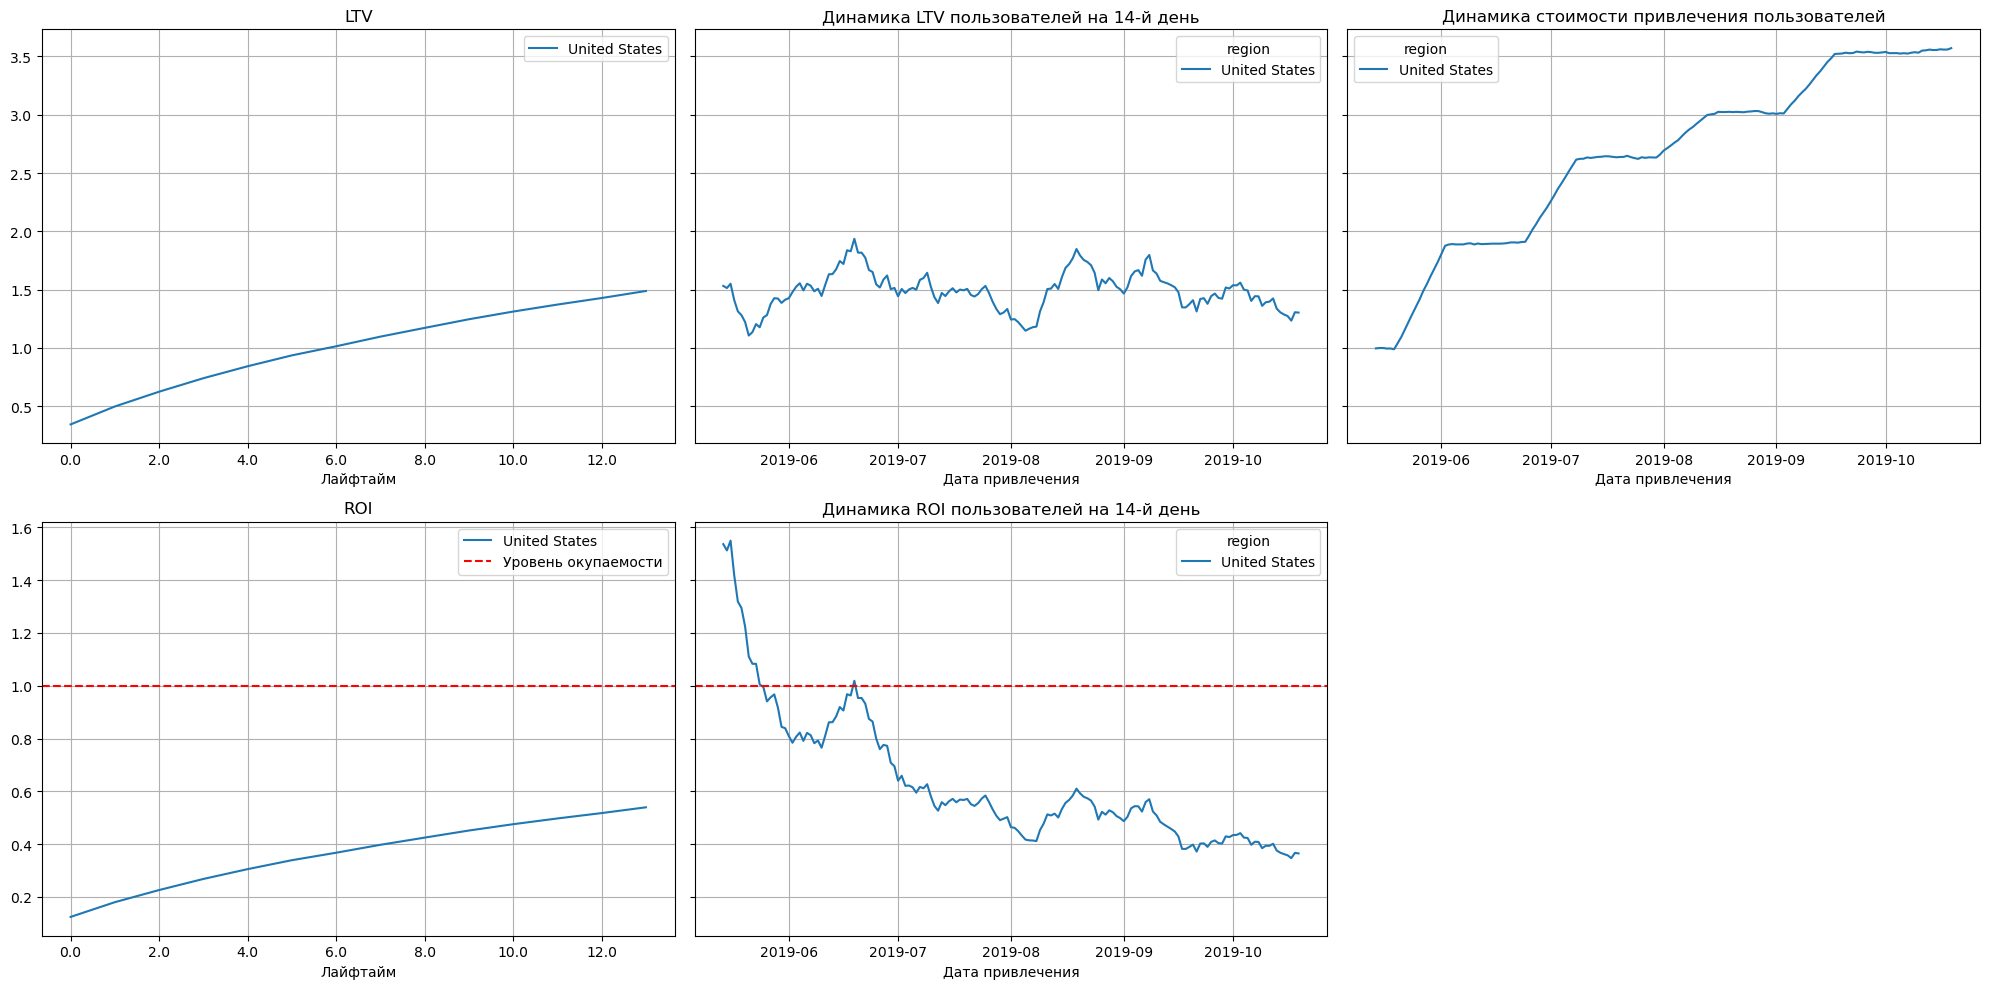

In [125]:
profiles_faceboom = profiles.query('channel == "TipTop"')
dimensions = ['region']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles_faceboom, orders, observation_date, horizon, dimensions)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon, window)

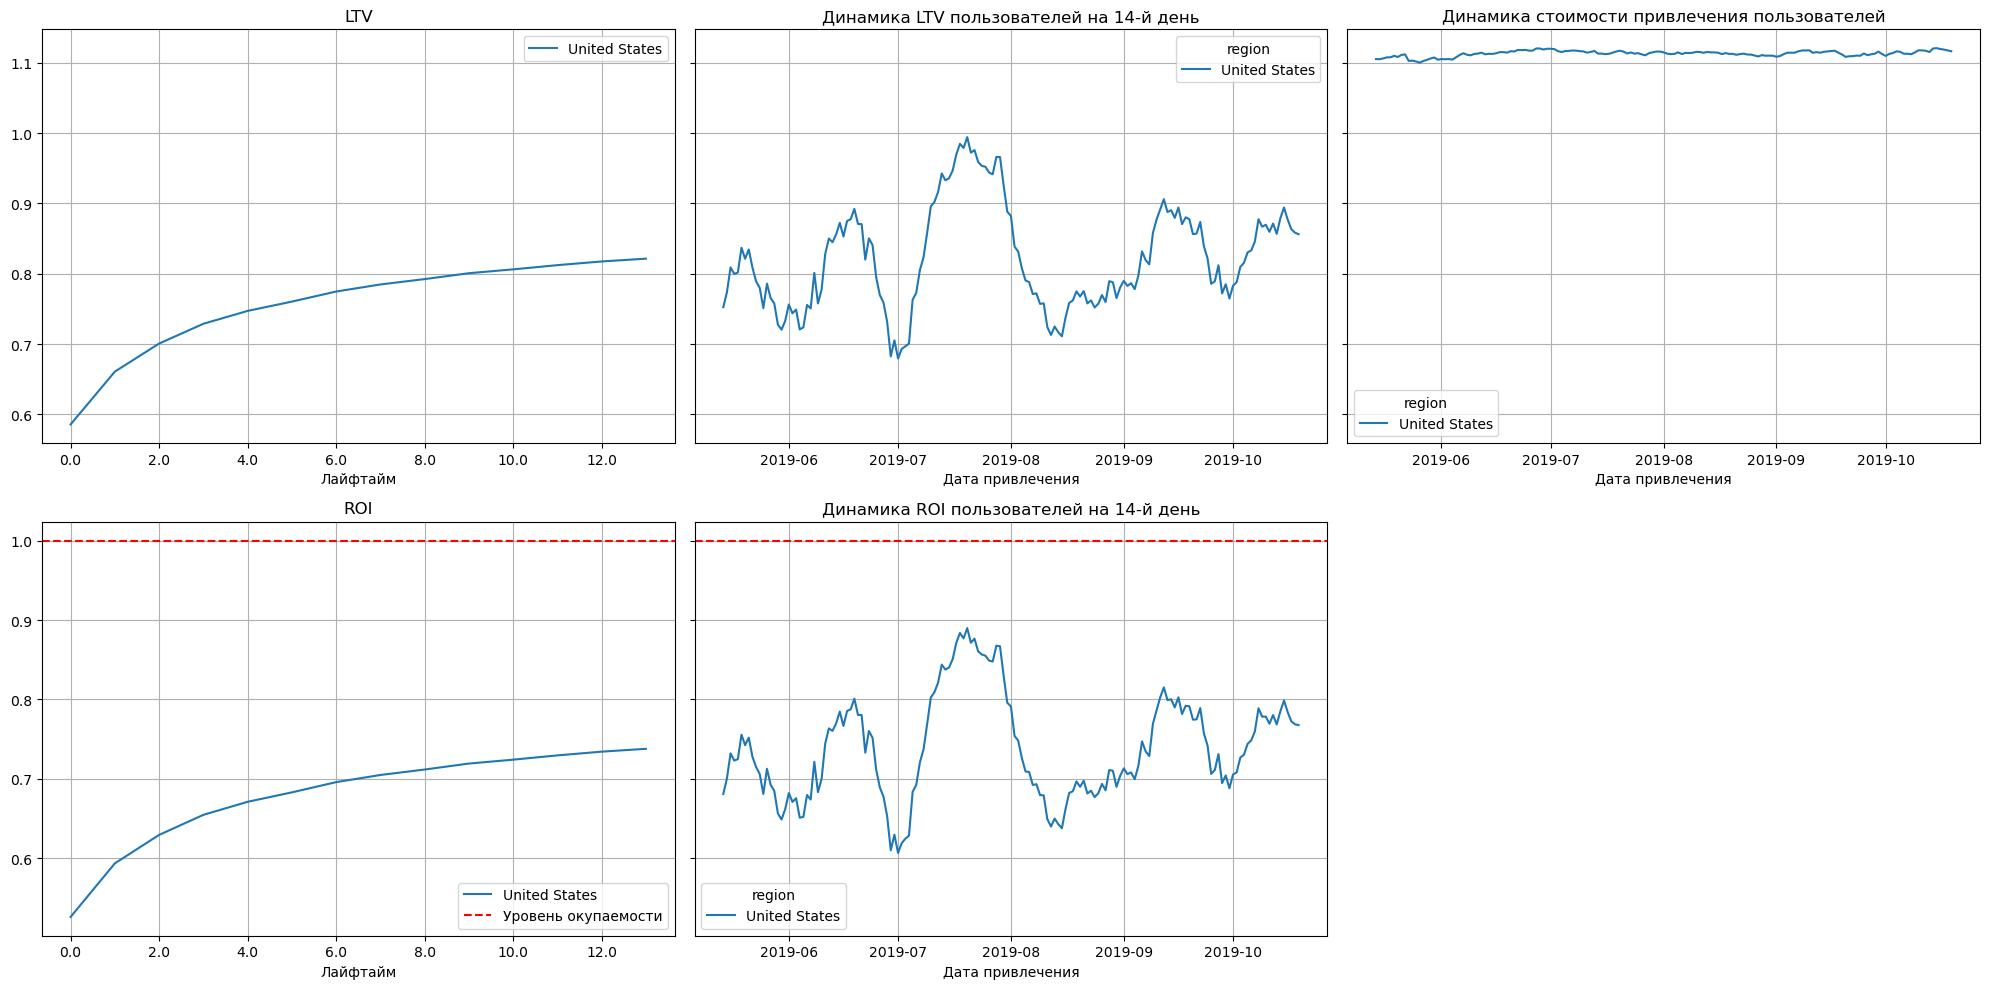

In [126]:
profiles_faceboom = profiles.query('channel == "FaceBoom"')
dimensions = ['region']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles_faceboom, orders, observation_date, horizon, dimensions)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon, window)

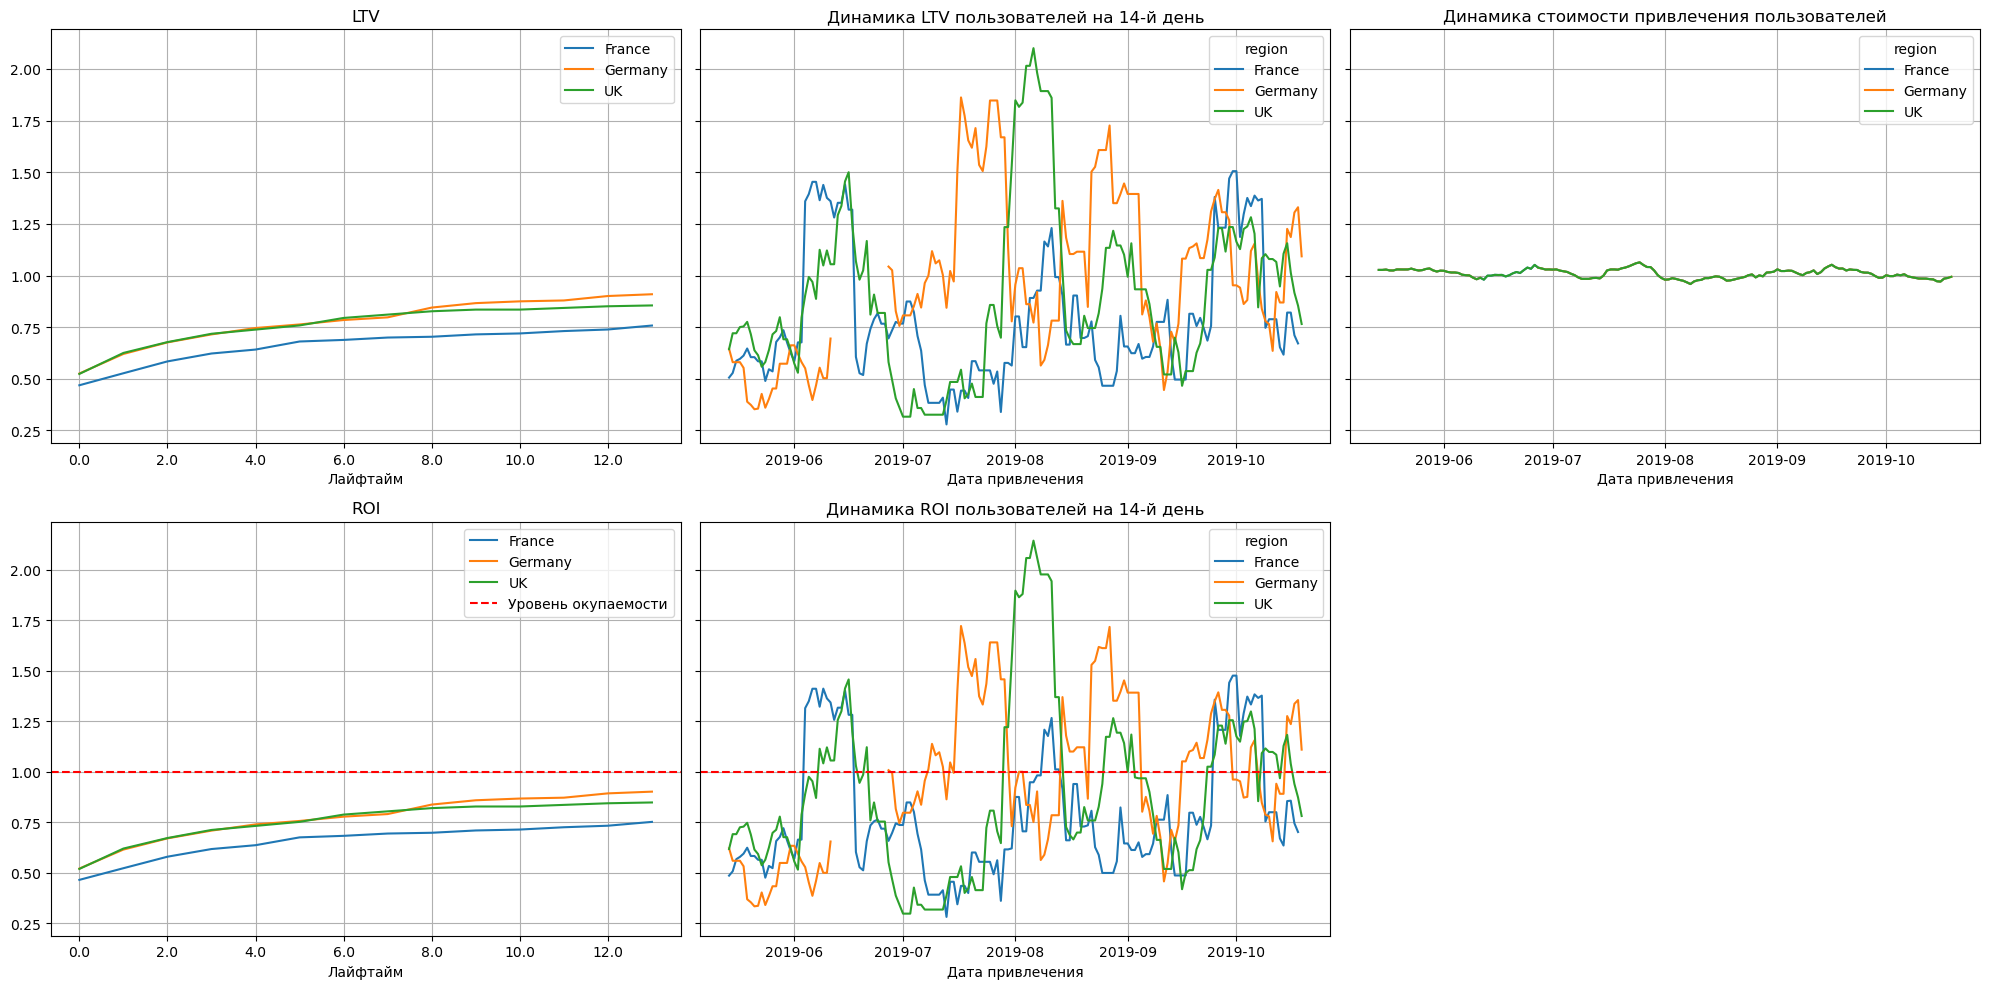

In [127]:
profiles_faceboom = profiles.query('channel == "AdNonSense"')
dimensions = ['region']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles_faceboom, orders, observation_date, horizon, dimensions)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon, window)

* На графике LTV видны лидеры: 1 это lambdaMediaAds, на 2 месте Tiptop
* На динамике LTV все трафики похожи, но выделяется lambdaMediaAds
* Динамика стоимости привлечения практически у всех не меняется в течение всего периода, либо вовсе спадает. Но TipTop только увеличивается. На втором месте по дороговизне FaceBoom.
* Окупаются все трафики за исключением: TipTop, FaceBoom, AdNonSense. Такая же ситуация и на динамике окупаемости на 14 день.

Рекомендовал бы маркетологам пересмотреть рекламные договоры с такими трафиками, как TipTop, AdNonSense и FaceBoom. Поскольку они не являются выгодными для компании, а, наоборот, приносят одни убытки.


---

## Вопросы:

1. Окупается ли реклама, направленная на привлечение пользователей в целом?
2. Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
3. Чем могут быть вызваны проблемы окупаемости?

### Ответы:

1. В целом реклама не окупается за 14 дней, только еле-еле подходит к 80% от затрат.
2. Проведя анализ, точно можно сказать, что во всем вина стоимости привлечения клиентов через такие трафики, как TipTop, FaceBoom и AdNonSense. Также было замечено. что именно в стране United States привлеченные пользователи не окупаются, возможно, большинство пришедших оттуда это пользователи, перешедшие через ранее указанные трафики. Себя окупают только пользователи PC, пользователи с другими устройствами приносят убытки компании.
3. Проблемы окупаемости могли быть вызваны по причине повышения стоимости одного привлеченного клиента из конкретного графика. Либо же реклама сама по себе является не выгодной для компании.

---

# Вывод

Нам был дан кейс, и мы провели предобработку данных, задали функции для расчета нужных метрик, провели исследовательский анализ данных, провели анализ маркетинга, оценили окупаемость рекламы и выяснили, в чем основные проблемы кампаний. Проведя предобработку данных, не было замечено никаких проблем с данными, кроме неправильных типов данных. Поменяли на нужные, а если точнее, то были неверными только столбцы с датами, все исправили и подготовили. Далее задали нужные функции, с этим проблем не возникло. Провели исследовательский анализ данных: выяснили, что минимальная дата привлечения - 1 мая 2019 года, максимальная дата привлечения - 27 октября 2019 года. Для упрощенной работы написали новые функции. Сравнили страны по количеству их пользователей: лидирует США с отметкой в 100002 пользователей, далее с небольшой разницей идут такие страны, как: Великобритания(17575), Франция(17450), Германия(14981). Лидер по доле платящих пользователей все тот же, но отрыв уже не так велик: США(0.07), Германия(0.041), Великобритания(0.04), Франция(0.038). Сравнили устройства, с которых сидят пользователи: по количеству пользователей лидирует iPhone с большим отрывом(54479). Далее идут такие устройства, как Android(35032), PC(30455), Mac(30042). А в долях покупателей прошлый лидер уже скатился до второго места с небольшой разницей: Mac(0.063), iPhone(0.062), Android(0.059), PC(0.05). Следующим критерием для сравнения были трафики: лидирует organic, на втором месте FaceBoom. Зато в доле платящих на первых местах: FaceBoom, AdNonSense, lambdaMediaAds, TipTop, RocketSuperAds. Organic находится на последнем месте. После этого мы приступили к анализу маркетинга. Всего было потрачено на рекламу - 105497,3. Самыми дорогими источниками оказилсь TipTop и FaceBoom. Расходы на них увеличивались в течение всего периода. При этом самый "дорогой" пользователь приходил из TipTop, когда пользователь из FaceBoom был уже не настолько дороже, по сравнению с остальными источниками. Далее проанализировали окупаемость рекламы. В целом реклама не окупалась, к 14 дню приходил доход, равный лишь 80% расходов. Выяснили, что худшая конвертация у пользователей с устройством PC, при этом окупаются они лучше всех, чего не скажешь о iPhone, Mac и Android. В сравнении по странам выявили, что все страны примерно одинаковы, но United States хуже всех удерживаются, но лучше всех конвертируются. При этом пользователи из этой страны все равно не окупались, когда все остальные страны окупаются уже на 2-3 день после прихода в приложение. Теперь к самому главному: рекламные каналы. Динамика стоимости у всех равномерная в течение всего периода за исключением TipTop. Она аномально растет, начиная с июня. При этом мы помним, что расходы росли на рекламу в TipTop и FaceBoom. Это означает, что цена рекламы в TipTop не пропорционально растет по отношению с количеством привлеченных пользователей, и то, что количество привлеченных пользователей из FaceBoom росло пропорционально с ростом цены за рекламу. При этом данный трафик все равно не окупал себя. Так же выяснили, реклама через AdNonSense тоже не окупает себя. Для подробного анализа нарисовали графики про эти три трафика: TipTop стал слишком дорогим, при этом пользователи, приходящие оттуда, платят не так много в приложении. FaceBoom хоть и позакывал хорошие результаты в конвертации и в сумме денег, которые тратили пользователи из этого источника, но все же реклама является слишком дорогой и не окупает себя. AdNonSense стоит не так дорого, но все так же не окупает себя.

Рекомендации для отдела маркетинга:
* Пересмотреть рекламу через такие источники, как Tiptop, FaceBoom и AdNonSense. Они единственные себя не окупают. TipTop стоит больше половины всего рекламного бюджета, при этом хуже всех окупается. Пользователи из FaceBoom показывают хорошие результаты в платежеспособности, но реклама стоит слишком дорого, поэтому себя не окупает. Прошу обратить внимание на такие источники, как YRabbit, MediaTornado, RocketSuperAds, LeapBob, lambdaMediaAds, ведь они окупаются уже 2 день после привлечения клиентов. Трафики WahooNetBanner, OppleCreativeMedia тоже хороши, окупаются на 4 день.
* Стоит пересмотреть платформы, с которых могут приходить пользователи страны United States. Поскольку они показывают лучшие результаты по доле платящих пользователей и конверсии. И при этом компания привлекла больше всего пользователей именно из этой страны. Но страна себя не окупила, видимо, многие ее граждане перешли через ранее перечисленные источники. Такой вывод был сделан из-за динамики изменения цены за одного привлеченного пользователя, она начала аномально расти в тот же момент, что и источник TipTop.
* По поводу устройств можно сказать все равны, но, iPhone и Mac единственные поднялись в цене одинаково высоко по сравнению с Android и PC. При этом денег они тратят больше всех остальных устройств. Видимо, пользователи с устройствами iPhone и Mac приходят в основном из тех же источников, что мы перечислили во втором пункте.